# <mark>***Data read in***<mark>
---

##### <center> <span style='color:gray'> import & class<span style='color:gray'> </center>

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [
                tf.config.experimental.VirtualDeviceConfiguration(
                    memory_limit=5120)
            ])
    except RuntimeError as e:
        print(e)

import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Button
from ipywidgets import IntSlider
from ipywidgets import interact

import numpy as np
import pandas as pd

import os
from os import listdir
from os.path import isfile, join

import random
import math

import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

import category_encoders as ce

import warnings

warnings.filterwarnings("ignore")

In [79]:
ori_data.dict_df["Read"]["float"]

,x,y,z
0,-3.933798,3.816021,0.054624
1,-3.146028,4.944571,-0.709159
2,-3.945641,3.505150,-0.192093
3,-3.578409,3.798706,0.509541
4,-3.853849,3.311089,-0.325212
...,...,...,...
3295,-3.237041,5.023614,0.161914
3296,-3.224792,4.989875,0.401997
3297,-4.557238,4.865120,-0.757247
3298,-2.918684,4.974607,0.555049


In [80]:
class Original_Data:
    # 建構式
    def __init__(self, df_read, name, sep_char="."):
        self.dict_df = {"Categorical":[], "OneHot":[], "Ordinal":[], "Target":[]}
        for k in self.dict_df.keys(): self.dict_df[k] = {"All":[], "Train":[], "Test":[]}
        self.dict_df["Read"] = {}

        self.dict_df["Read"]["All"] = df_read.copy()
        self.sep_char = sep_char
        self.name = name
        self.name_label = df_read.columns[-1]
        ### check df_read type
        df = self.dict_df["Read"]["All"].iloc[:,:-1].copy()

        id_bin = [i for i, c in enumerate(df.columns)  if len(df[c].unique()) == 2]
        col_type = [str(df[c].dtypes) for c in df.columns]

        id_int = [i for i, t in enumerate(col_type) if "int" in t  if i not in id_bin]
        id_float = [i for i, t in enumerate(col_type) if "float" in t  if i not in id_bin]
        id_obj = [i for i, t in enumerate(col_type) if t == 'object'  if i not in id_bin]
        
        self.dict_df["Read"]["bin"] = df[[df.columns[c] for c in id_bin]].copy()
        self.dict_df["Read"]["int"] = df[[df.columns[c] for c in id_int]].copy()
        self.dict_df["Read"]["float"] = df[[df.columns[c] for c in id_float]].copy()
        self.dict_df["Read"]["obj"] = df[[df.columns[c] for c in id_obj]].copy()
        self.dict_df["OneHot"]["All"] = pd.DataFrame()
        self.dict_df["Categorical"]["All"] = pd.DataFrame()
    # 方法(Method)
    def check_df_read_type(self,):
        df = self.dict_df["Read"]["All"].iloc[:,:-1].copy()
        col_type = [str(df[c].dtypes) for c in df.columns]
        self.col_type = col_type
        return col_type

    ### generate bin or categorical data
    def trans_onehot_from_cont(self, bc, df_read):
        ### make cont. data to binary columns
        # self.dict_df["Continuous"] = {"All":[], "Train":[], "Test":[]}
        # self.dict_df["Continuous"]["All"] = df_read.copy()
        df = df_read.copy()
        gap, n_feat, new_data = [0], 0, []
        label_encoder = LabelEncoder()
        # finding slicing gap
        for c in df.columns:
            mx, mn = int(max(df[c])) + 1, int(min(df[c])) - 1
            n_bins = int(bc / 3)
            n_feat = n_feat + n_bins
            gap.append(n_feat)
            y = label_encoder.fit_transform(
                pd.cut(df[c], n_bins, retbins=True)[0])
            new_data.append(list(y))
        df_new = pd.DataFrame(new_data)

        # changing data gird in to binary
        df = df_new.T
        new_data = []
        for r in df.values:
            l_1 = []
            nr_data = []
            for i in range(0, len(gap) - 1):
                l_1.append(gap[i] + r[i])
            for i in range(0, gap[-1]):
                if i in l_1:
                    nr_data.append(1)
                else:
                    nr_data.append(0)
            new_data.append(nr_data)
            
        # adding feature name
        n_f_name = []
        cur = 0
        s = 96
        for i in range(0, gap[-1]):
            if i >= gap[cur]:
                cur = cur + 1
                s = s + 1
            n_f_name.append(f"{chr(s)}{self.sep_char}{i-gap[cur-1]+1}")

        # generating new binary data
        df_new = pd.DataFrame(new_data)
        df_new.columns = n_f_name
        df_new['GB'] = self.dict_df["Read"]["All"][self.name_label]
        self.dict_df["OneHot"]["All"] = df_new
        self.bin_feat = len(df_new.columns[:-1])
        self.get_sep_and_col()
        
    def trans_onehot_from_bin(self, df_read):
        df = df_read.copy()
        self.dict_df["OneHot"]["All"] = pd.concat([self.dict_df["OneHot"]["All"],df], axis=1)

    def trans_onehot_from_obj(self, df_read):
        ### change categorical column to binary columns
        df = df_read.copy()
        for c in df.columns:
            # Get one hot encoding of columns B
            one_hot = pd.get_dummies(df[c])
            one_hot.columns = [
                f"{c}{self.sep_char}{i}" for i in range(0, len(one_hot.columns))
            ]
            # Drop column B as it is now encoded
            df = df.drop(c, axis=1)
            # Join the encoded df
            df = df.join(one_hot)
        # col = list([c for c in df.columns if c != "GB"]) + ["GB"]
        # df = df[col]
        # pd.concat([df1, df4], axis=1)
        self.dict_df["OneHot"]["All"] = pd.concat([self.dict_df["OneHot"]["All"],df], axis=1)

    def trans_categorical_form_onehot(self,): 
        ### reverse onehot encode
        self.get_sep_and_col()
        sep = self.sep
        df = self.dict_df["OneHot"]["All"].copy()
        df_new = pd.DataFrame()
        for i, s in enumerate(sep[:-1]):
            df_sep = df.iloc[:, s:sep[i + 1]]
            if (sep[i+1]-s)!=1:             
                df_sep['tags'] = ''
                # to create an empty column
                for col_name in df_sep.columns:
                    df_sep.loc[df_sep[col_name] == 1,
                               'tags'] = df_sep['tags'] + ' ' + col_name
                df_new[df.columns[s].split(self.sep_char)[0]]=df_sep['tags']
            else:
                df_new[df.columns[s]]=df_sep
        df_new = df_new.replace("","0")
        df_new[self.name_label] = self.dict_df["OneHot"]["All"][self.name_label]
        self.dict_df["Categorical"]["All"] = df_new.copy()
        

    ### get sep and col_names
    def get_sep_and_col(self,):
        if  self.name_label not in self.dict_df["OneHot"]["All"].columns:
            self.dict_df["OneHot"]["All"][self.name_label] = self.dict_df["Read"]["All"][self.name_label]
        sep_char = self.sep_char
        col = self.dict_df["OneHot"]["All"].copy().columns[:-1]
        pre_c = col[0].split(sep_char)[0]
        sep, col_name = [0], [pre_c]
        for i in range(0, len(col)):
            new_c = col[i].split(sep_char)[0]
            if pre_c != new_c:
                sep.append(i)
                col_name.append(new_c)
            pre_c = new_c
        sep.append(len(col))
        self.n_group = len(sep) - 1
        self.sep = sep
        self.col_name = col_name
        
        return self.sep, self.col_name

    def set_keep_data_type(self,list_type):
        self.list_type = list_type
    
    ### column droping
    def drop_onecol_eachgroup_rnd(self, ):
        self.get_sep_and_col()
        cols, col_list = self.dict_df["OneHot"]["All"].columns, [
            i for i in range(0, len(self.dict_df["OneHot"]["All"].columns))
        ]
        ax, l_drop = int(len(self.dict_df["OneHot"]["All"].columns[:-1]) / 3), []
        for i in range(0, 3):
            l_drop.append(i * ax + random.randint(0, ax - 1))
        self.dict_df["OneHot"]["All"] = self.dict_df["OneHot"]["All"].iloc[:, [
            col for col in col_list if col not in l_drop
        ]]
        self.bin_feat = len(self.dict_df["OneHot"]["All"].columns[:-1])
        self.get_sep_and_col()
        return [cols[col] for col in l_drop]

    def drop_onecol_eachgroup_minsum(self, ):
        self.get_sep_and_col()
        cols, df, sep = self.dict_df["OneHot"]["All"].columns, self.dict_df["OneHot"]["All"].copy(), self.sep
        l_sum, l_drop = [sum(df[c]) for c in cols[:-1]], []
        for i, s in enumerate(sep[:-1]):
            l = l_sum[s:sep[i + 1]]
            l_drop.append(l.index(min(l)) + s)
        l_drop = cols[l_drop]
        self.dict_df["OneHot"]["All"] = df[[c for c in df if c not in l_drop]]
        self.bin_feat = len(self.dict_df["OneHot"]["All"].columns[:-1])
        self.get_sep_and_col()
        return l_drop

    def drop_zero_col(self, ):
        zero_col = [
            c for c in self.dict_df["OneHot"]["All"].columns[:-1]
            if sum(list(self.dict_df["OneHot"]["All"][c])) == 0
        ]
        self.dict_df["OneHot"]["All"] = self.dict_df["OneHot"]["All"].drop(columns=zero_col)
        self.bin_feat = len(self.dict_df["OneHot"]["All"].columns[:-1])
        self.get_sep_and_col()
        return zero_col

    ### split data
    def spilt_train_and_test(self, ratio):
        X, y = self.dict_df["OneHot"]["All"].iloc[:, :-1], self.dict_df["OneHot"]["All"].iloc[:, -1:]
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            train_size=ratio,
                                                            stratify=y)
        X_train[y_train.columns[0]] = y_train
        X_test[y_test.columns[0]] = y_test
        self.df_train = X_train
        self.df_test = X_test

    def spilt_SKFold(self, split):
        kf = StratifiedKFold(n_splits=split, shuffle=True)
        df = self.dict_df["Categorical"]["All"]
        X, y = df.iloc[:, :-1], df.iloc[:, -1:]
        results = list(kf.split(X, y))
        self.kFolds = results

    def set_folds(self, fold_num):
        self.fold_num = fold_num
        fold = self.kFolds[fold_num]    
        self.encode_ordinal()
        self.encode_target()  
        for k in self.dict_df.keys():
            if k == "Read": continue
            self.dict_df[k]["Train"]=self.dict_df[k]["All"].iloc[fold[0]].copy()
            self.dict_df[k]["Test"]=self.dict_df[k]["All"].iloc[fold[1]].copy()

    ### encode funs
    def encode_ordinal(self, ):
        fold = self.kFolds[self.fold_num]
        df = self.dict_df["Categorical"]["All"].copy()
        for c in df.columns: df[c] = pd.factorize(df[c])[0] + 1
        col = list([c for c in df.columns if c != self.name_label])
        df = df[col]
        ### adding keeping parts of df_read
        for t in self.list_type:df = pd.concat([df,self.dict_df["Read"][t]],axis=1)
        df[self.name_label] = self.dict_df["Categorical"]["All"][self.name_label].copy()
        self.dict_df["Ordinal"]["All"] = df.copy()

    def encode_target(self, ):
        fold = self.kFolds[self.fold_num]
        df = self.dict_df["Categorical"]["All"].copy()
        for col_name in df.columns:
            tenc = ce.TargetEncoder()
            df_tar = tenc.fit_transform(df[col_name], df['GB'])
            df = df_tar.join(df.drop(col_name, axis=1))
        col = list([c for c in df.columns if c != self.name_label])
        df = df[col]
        ### adding keeping parts of df_read
        for t in self.list_type:df = pd.concat([df,self.dict_df["Read"][t]],axis=1)
        df[self.name_label] = self.dict_df["Categorical"]["All"][self.name_label].copy()
        self.dict_df["Target"]["All"] = df.copy()

## ***<span style='color:purple'>AUO Data<span style='color:purple'>***

### example

In [56]:
name_df = "Mach"
path_df = rf"C:\Users\User\Desktop\Terry\Data\Datasets\AUO\{name_df}.csv"
df_auo = pd.read_csv(path_df, index_col=0)
print(df_auo.shape)
df_auo.head()

(205797, 118)


,ASxSTO,ASvCVD,ASvCVD.1,ASvCVD.2,ASvCVD.3,ASvCVD.4,ASvRIE,ASvRIE.1,ASvRIE.2,ASvRIE.3,...,THvOUT.1,THvOUT.2,THvOUT.3,THvRIE,THvRIE.1,THvRIE.2,THvSTO,THvSTO.1,THvSTO.2,GB
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,1
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1
3,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,1,0,1
4,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,1,0,0,1


In [57]:
### (1) read in csv
ori_data = Original_Data(df_auo, ".","AUO")

# ### (2) slicing to binary
ori_data.df_bin_from_cate()
ori_data.df_cate_form_bin()
ori_data.df_bin_from_cate()
# # ### (3) Check slice out empty
# ori_data.drop_zero_col()

# # ### (4) drop one column on each axis
# # ori_data.drop_one_col_minsum()

# # ### (5) get sep and col
# ori_data.get_sep_and_col(".")

# # ### (6) split train and test
# # # ori_data.spilt_train_and_test(0.75)

### (6) set k fold
ori_data.spilt_SKFold(4)
ori_data.set_folds(0)

In [58]:
gd_xyz = Grouped_Data(ori_data, "xyz")
gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
gd_xyz.set_col(ori_data.get_sep_and_col()[1])
gd_xyz.group_df()
# gd_rnd = Grouped_Data(ori_data, "Rnd")
# gd_rnd.set_seq(random.sample([i for i in range(0, gd_rnd.bin_feat)], gd_rnd.bin_feat))
# gd_rnd.set_col([f"r{i+1}" for i in range(ori_data.n_group)])
# gd_rnd.group_df()

In [59]:
gi_encoder = seq_encoder(gd_xyz,"gini")
gi_encoder.set_encode_funs(seq_ratio,sort_SmallToLarge,encode_category)
gi_encoder.encode_grid()

### run all

In [617]:
% % capture
df = df_new
ori_data = UCI_Data(df)
f1_score, re_score, pre_score = {}, {}, {}
SKFold = 4

# 1. read and slice data
ori_data.slice_to_bin()
ori_data.get_sep_and_col()
ori_data.spilt_SKFold(SKFold)
fold_f1, fold_re, fold_pre = [], [], []
for fold in range(0, SKFold):
    ori_data.set_folds(fold)
    ori_data.target_encode()
    ori_data.ordinal_encode()
    out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\AUO-before\fold {fold+1}"
    # 2. group columns
    # ........................................................
    # xyz
    gd_xyz = Grouped_Data(ori_data, "xyz")
    gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
    gd_xyz.set_col(cols[:-1])
    gd_xyz.group_df()
    # ### rnd
    gd_rnd = Grouped_Data(ori_data, "Rnd")
    gd_rnd.set_seq(
        random.sample([i for i in range(0, gd_rnd.bin_feat)], gd_rnd.bin_feat))
    gd_rnd.set_col(cols[:-1])
    gd_rnd.group_df()
    # ### pca
    gd_pca = Grouped_Data_PCA(ori_data, "PCA")
    gd_pca.set_seq()
    gd_pca.set_col(cols[:-1])
    gd_pca.group_df()
    # corr
    gd_corr = Grouped_Data_Corr(ori_data, "corr")
    gd_corr.set_seq()
    gd_corr.set_col(cols[:-1])
    gd_corr.group_df()

    dict_gd = {}
    dict_gd = {"xyz": gd_xyz, "Rnd": gd_rnd, "PCA": gd_pca, "Corr": gd_corr}
    # 3. encoding
    # ........................................................
    dict_train, dict_test = {}, {}
    dict_train["OneHot"], dict_test[
        "OneHot"] = ori_data.df_train, ori_data.df_test
    dict_train["Ordinal"], dict_test[
        "Ordinal"] = ori_data.df_ori_train, ori_data.df_ori_test
    dict_train["Mean"], dict_test[
        "Mean"] = ori_data.df_tar_train, ori_data.df_tar_test
    for name_gd in dict_gd:
        paths = []
        group_data = dict_gd[name_gd]
        # ground truth
        if name_gd == "xyz":
            gt_encoder = seq_encoder(group_data, f"{name_gd} / ID")
            gt_encoder.set_encode_funs(seq_ID, sort_LargeToSmall,
                                       encode_category)
            gt_encoder.encode_grid()
            # paths.append(plot_compare_all(ori_data, group_data, gt_encoder, gt_encoder.df_grid))
            dict_train[f"{gt_encoder.name}"], dict_test[
                f"{gt_encoder.name}"] = gt_encoder.df_grid_train, gt_encoder.df_grid_test
        # sum
        sum_encoder = seq_encoder(group_data, f"{name_gd} / Sum")
        sum_encoder.set_encode_funs(seq_sum, sort_SmallToLarge,
                                    encode_category)
        sum_encoder.encode_grid()
        # paths.append(plot_compare_all(ori_data, group_data, sum_encoder, sum_encoder.df_grid))
        dict_train[f"{sum_encoder.name}"], dict_test[
            f"{sum_encoder.name}"] = sum_encoder.df_grid_train, sum_encoder.df_grid_test

        # gini
        gi_encoder = seq_encoder(group_data, f"{name_gd} / gini")
        gi_encoder.set_encode_funs(seq_ratio, sort_SmallToLarge,
                                   encode_category)
        gi_encoder.encode_grid()
        # paths.append(plot_compare_all(ori_data, group_data, gi_encoder, gi_encoder.df_grid))
        dict_train[f"{gi_encoder.name}"], dict_test[
            f"{gi_encoder.name}"] = gi_encoder.df_grid_train, gi_encoder.df_grid_test

        # rnd
        rnd_encoder = seq_encoder(group_data, f"{name_gd} / Rnd")
        rnd_encoder.set_encode_funs(seq_rnd, sort_LargeToSmall,
                                    encode_category)
        rnd_encoder.encode_grid()
        # paths.append(plot_compare_all(ori_data, group_data, rnd_encoder, rnd_encoder.df_grid))
        dict_train[f"{rnd_encoder.name}"], dict_test[
            f"{rnd_encoder.name}"] = rnd_encoder.df_grid_train, rnd_encoder.df_grid_test
    # 4. Classification
    # ........................................................
    df_all, dict_clf, dict_eval, dict_cm = cal_all_dfs(dict_train, dict_test)
    df_all = df_all.fillna(0)
    df_all = df_all.applymap(lambda x: str(int(x))
                             if abs(x - int(x)) < 1e-6 else str(round(x, 4)))
    fold_f1.append(list(np.concatenate(df_all.loc[["f1_score"]].values).flat))
    fold_re.append(list(np.concatenate(df_all.loc[["recall"]].values).flat))
    fold_pre.append(list(
        np.concatenate(df_all.loc[["precision"]].values).flat))
    # plot_class_all(df_all, dict_cm, bc)

f1_score[f"bc"] = np.mean(np.array(fold_f1).astype(np.float), axis=0)
re_score[f"bc"] = np.mean(np.array(fold_re).astype(np.float), axis=0)
pre_score[f"bc"] = np.mean(np.array(fold_pre).astype(np.float), axis=0)
# out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})"


In [618]:
score_all = []
score_all.append(list(re_score['bc']))
score_all.append(list(pre_score['bc']))
score_all.append(list(f1_score['bc']))
# output class score
df_class = pd.DataFrame(score_all)
df_class.columns = df_all.columns
df_class.index = ["recall", "precision","f1 score"]
df_class = df_class.round(decimals = 4)
df_class.index.name = "Binary features"
df_class

,OneHot,Ordinal,Mean,xyz / ID,xyz / Sum,xyz / gini,xyz / Rnd,Rnd / Sum,Rnd / gini,Rnd / Rnd,PCA / Sum,PCA / gini,PCA / Rnd,Corr / Sum,Corr / gini,Corr / Rnd
Binary features,,,,,,,,,,,,,,,,
recall,0.0,0.0,0.0,0.0111,0.0,0.0054,0.0109,0.0,0.0111,0.0165,0.0,0.0165,0.0165,0.0,0.0054,0.0056
precision,0.0,0.0,0.0,0.0009,0.0,0.0001,0.0009,0.0,0.0005,0.0009,0.0,0.0010,0.0014,0.0,0.0001,0.0005
f1 score,0.0,0.0,0.0,0.0017,0.0,0.0002,0.0016,0.0,0.0010,0.0018,0.0,0.0019,0.0025,0.0,0.0002,0.0010


In [619]:
std_all = []
df_fold = pd.DataFrame(fold_re, columns = df_all.columns)
std_all.append([np.std([float(i) for i in df_fold[c]]) for c in df_fold])
df_fold = pd.DataFrame(fold_pre, columns = df_all.columns)
std_all.append([np.std([float(i) for i in df_fold[c]]) for c in df_fold])
df_fold = pd.DataFrame(fold_f1, columns = df_all.columns)
std_all.append([np.std([float(i) for i in df_fold[c]]) for c in df_fold])
# output class score
df_std = pd.DataFrame(std_all)
df_std.columns = df_all.columns
df_std.index = ["recall", "precision","f1 score"]
df_std = df_std.round(decimals = 6)
df_std.index.name = "Binary features"
df_std

,OneHot,Ordinal,Mean,xyz / ID,xyz / Sum,xyz / gini,xyz / Rnd,Rnd / Sum,Rnd / gini,Rnd / Rnd,PCA / Sum,PCA / gini,PCA / Rnd,Corr / Sum,Corr / gini,Corr / Rnd
Binary features,,,,,,,,,,,,,,,,
recall,0.0,0.0,0.0,0.0111,0.0,0.009396,0.018836,0.0,0.011100,0.018371,0.0,0.018371,0.009543,0.0,0.009396,0.009613
precision,0.0,0.0,0.0,0.0009,0.0,0.000217,0.001516,0.0,0.000505,0.000978,0.0,0.001010,0.001334,0.0,0.000217,0.000909
f1 score,0.0,0.0,0.0,0.0017,0.0,0.000433,0.002815,0.0,0.000991,0.001874,0.0,0.001921,0.002321,0.0,0.000433,0.001689


In [620]:
# dataset_name = "Car Evaluation Data Set"
out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\\AUO-before\\{name_data}"
plot_UCI_score(df_class,df_std, dataset_name,SKFold)

In [621]:
# name_data = "Machine"
name_data = "Chamber"
df_auo = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Datasets\Backup\{name_data[:4]}.csv", index_col=0,).iloc[2:,:]
for c in df_auo:
    df_auo[c] = df_auo[c].astype(float)
    df_auo[c] = df_auo[c].astype(int)
df_auo.columns = [c.replace("-", "一") for c in list(df_auo.columns)]
df_auo.index = [i for i in range(0, len(df_auo))]
df_auo.head()

,AS+STO,AS一CVD,AS一CVD.1,AS一CVD.2,AS一CVD.3,AS一CVD.4,AS一CVD.5,AS一CVD.6,AS一CVD.7,AS一CVD.8,...,TH一RIE.5,TH一RIE.6,TH一RIE.7,TH一RIE.8,TH一RIE.9,TH一RIE.10,TH一STO,TH一STO.1,TH一STO.2,GB
0,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [615]:
cols, sep= [],[]
for i, c in enumerate( df_auo.columns):
    if "." not in c : 
        cols.append(c)
        sep.append(i)

In [616]:
df_new = pd.DataFrame()
df = df_auo
for i,s in enumerate( sep[:-1]) :
    df_sep = df.iloc[:,s:sep[i+1]]
    col = df.columns[s]
    if sep[i+1]-s != 1:
        df_sep['tags']=[0]*len(df)
        for col_name in df_sep.columns:
            if '.' in col_name:name = col_name.split('.')[-1]
            else: name = 0
            df_sep.loc[df_sep[col_name]==1,'tags'] = str(name)
        df_new[col] = df_sep['tags']
    else: df_new[col] = df[col]
df_new['GB'] = df['GB']
# df_new.fillna(value=0)
df_new.head()

,AS+STO,AS一CVD,AS一RIE,CL一RIE,CL一STO,CL一WMA,GL+CLA,GL+IEX,GL+SPT,GL+STO,...,SL一WMA,TH+IEX,TH+STO,TH+STO2,TH一BAK,TH一IEX,TH一OUT,TH一RIE,TH一STO,GB
0,0,1,9,10,0,0,0,0,0,0,...,2,0,0,0,0,3,0,5,1,1
1,0,5,9,8,1,0,0,0,0,0,...,2,0,0,0,0,4,0,2,0,1
2,0,3,15,13,1,0,0,0,0,0,...,2,0,0,0,0,4,0,5,1,1
3,0,26,13,12,1,0,0,0,0,0,...,2,0,0,0,0,3,0,5,1,1
4,0,29,6,14,0,0,0,0,0,0,...,2,0,0,0,0,2,0,6,0,1


## ***<span style='color:gray'>UCI Data<span style='color:gray'>***

In [52]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num","marital_status", "occupation", "relationship", "race", "gender","capital_gain", "capital_loss", "hours_per_week", "native_country","GB"]
df_adult = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",names=COLUMNS,sep=r'\s*,\s*',engine='python',na_values="?")
l = []
for i in df_adult["GB"]:
    if i != ">50K":l.append(0)
    else: l.append(1)
df_adult["GB"] = l

In [56]:
name = "car"
df_car = pd.read_csv(f'https://archive.ics.uci.edu/ml/machine-learning-databases/{name}/{name}.data')

df_car.columns = ["price", "maintenance", "doors", "persons", "luggage size","safety", "GB"]
# df_car.columns = ["c", "m", "d", "p", "l","s", "GB"]
l = []
for i in df_car["GB"]:
    if i != "unacc":l.append(1)
    else: l.append(0)
df_car["GB"] = l

In [599]:
df_ins = pd.read_csv(r'C:\Users\User\Desktop\Terry\Data\Datasets\aug_train.csv')
df_ins = df_ins.drop(columns = "id")
df_ins.columns = df_ins.columns[-1:]+["GB"]
df_ins.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [730]:
import pandas as pd;
data = [['Salt Lake City', 10, 120], ['Seattle', 5, 120], ['San Franscisco', 5, 140], 
        ['Seattle', 3, 100], ['Seattle', 1, 70], ['San Franscisco', 2, 100],['Salt Lake City', 1, 60], 
        ['San Franscisco', 2, 110], ['Seattle', 4, 100],['Salt Lake City', 2, 70] ]
df = pd.DataFrame(data, columns = ['City', 'Years OF Exp','Yearly Salary in Thousands'])
df

,City,Years OF Exp,Yearly Salary in Thousands
0,Salt Lake City,10,120
1,Seattle,5,120
2,San Franscisco,5,140
3,Seattle,3,100
4,Seattle,1,70
5,San Franscisco,2,100
6,Salt Lake City,1,60
7,San Franscisco,2,110
8,Seattle,4,100
9,Salt Lake City,2,70


In [733]:
col_name = "price"

tenc=ce.TargetEncoder() 
df_city=tenc.fit_transform(df[col_name],df['GB'])

df_new = df_city.join(df.drop(col_name,axis = 1))
df_new

,price,maintenance,doors,persons,luggage size,safety,GB
0,0.167053,vhigh,2,2,small,med,0
1,0.167053,vhigh,2,2,small,high,0
2,0.167053,vhigh,2,2,med,low,0
3,0.167053,vhigh,2,2,med,med,0
4,0.167053,vhigh,2,2,med,high,0
...,...,...,...,...,...,...,...
1722,0.402778,low,5more,more,med,med,1
1723,0.402778,low,5more,more,med,high,1
1724,0.402778,low,5more,more,big,low,0
1725,0.402778,low,5more,more,big,med,1


In [60]:
UCI_data = Original_Data(df_car, ".")
UCI_data.df_bin_from_cate()
# UCI_data.drop_zero_col()
UCI_data.get_sep_and_col()
# UCI_data.ordinal_encode()
UCI_data.spilt_SKFold(4)
UCI_data.set_folds(0)

In [764]:
%%capture
ori_data = UCI_Data(df_adult)
f1_score, re_score, pre_score = {},{},{}
SKFold = 10
# 1. read and slice data
#........................................................
ori_data.slice_to_bin()
ori_data.drop_zero_col()
# ori_data.drop_one_col_minsum()
ori_data.get_sep_and_col()
ori_data.spilt_SKFold(SKFold)
fold_f1, fold_re, fold_pre = [],[],[]
for fold in range(0,SKFold):
    ori_data.set_folds(fold)
    ori_data.ordinal_encode()
    ori_data.target_encode()
    # ori_data.spilt_train_and_test(0.75)
    out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\UCI\fold {fold+1}"
    # 2. group columns
    #........................................................
    ### xyz
    gd_xyz = Grouped_Data(ori_data,"xyz")
    gd_xyz.set_seq([i for i in range(0,ori_data.bin_feat)])
    gd_xyz.set_col(ori_data.get_sep_and_col()[1])
    gd_xyz.group_df()
    # ### rnd
    gd_rnd = Grouped_Data(ori_data,"Rnd")
    gd_rnd.set_seq(random.sample([i for i in range(0, ori_data.bin_feat)],ori_data.bin_feat))
    gd_rnd.set_col(ori_data.get_sep_and_col()[1])
    gd_rnd.group_df()
    # ### pca
    gd_pca = Grouped_Data_PCA(ori_data,"PCA")
    gd_pca.set_seq()
    gd_pca.set_col(ori_data.get_sep_and_col()[1])
    gd_pca.group_df()
    ### corr
    gd_corr = Grouped_Data_Corr(ori_data, "corr")
    gd_corr.set_seq()
    gd_corr.set_col(ori_data.get_sep_and_col()[1])
    gd_corr.group_df()

    dict_gd = {}
    dict_gd = {"xyz":gd_xyz,"Rnd":gd_rnd,"PCA":gd_pca, "Corr":gd_corr}
#     # dict_gd = {"xyz":gd_xyz,"Corr":gd_corr, "Corr ABS":gd_corrABS, "Corr Squre":gd_corrSqure}
    # 3. encoding
    #........................................................
    dict_train, dict_test = {}, {}
    dict_train["OneHot"], dict_test["OneHot"] = ori_data.df_train, ori_data.df_test
    dict_train["Ordinal"], dict_test["Ordinal"] = ori_data.df_ori_train, ori_data.df_ori_test
    dict_train["Mean"], dict_test["Mean"] = ori_data.df_tar_train, ori_data.df_tar_test
    for name_gd in dict_gd:
        paths = []
        group_data = dict_gd[name_gd]
        ### ground truth  
        if name_gd =="xyz":
            gt_encoder = seq_encoder(group_data,f"{name_gd} / ID" )
            gt_encoder.set_encode_funs(seq_ID,sort_LargeToSmall,encode_category)       
            gt_encoder.encode_grid()
            # paths.append(plot_compare_all(ori_data, group_data, gt_encoder, gt_encoder.df_grid))
            dict_train[f"{gt_encoder.name}"],dict_test[f"{gt_encoder.name}"] = gt_encoder.df_grid_train, gt_encoder.df_grid_test
        ### sum 
        sum_encoder = seq_encoder(group_data,f"{name_gd} / Sum")
        sum_encoder.set_encode_funs(seq_sum,sort_SmallToLarge,encode_category)       
        sum_encoder.encode_grid()
        # paths.append(plot_compare_all(ori_data, group_data, sum_encoder, sum_encoder.df_grid))
        dict_train[f"{sum_encoder.name}"],dict_test[f"{sum_encoder.name}"] = sum_encoder.df_grid_train,sum_encoder.df_grid_test

        ### gini
        gi_encoder = seq_encoder(group_data,f"{name_gd} / gini")
        gi_encoder.set_encode_funs(seq_ratio,sort_SmallToLarge,encode_category)
        gi_encoder.encode_grid()
        # paths.append(plot_compare_all(ori_data, group_data, gi_encoder, gi_encoder.df_grid))
        dict_train[f"{gi_encoder.name}"],dict_test[f"{gi_encoder.name}"] = gi_encoder.df_grid_train, gi_encoder.df_grid_test

        ### rnd  
        rnd_encoder = seq_encoder(group_data,f"{name_gd} / Rnd" )
        rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category) 
        rnd_encoder.encode_grid()
        # paths.append(plot_compare_all(ori_data, group_data, rnd_encoder, rnd_encoder.df_grid))
        dict_train[f"{rnd_encoder.name}"],dict_test[f"{rnd_encoder.name}"] = rnd_encoder.df_grid_train,rnd_encoder.df_grid_test

#         if name_gd == "PCA": 
#             for p in paths:
#                 with open(p, 'a') as file:file.write(group_data.plot_pca_group().to_html(full_html=False, include_plotlyjs='cdn'))
#         elif name_gd == "Corr": 
#             for p in paths:
#                 with open(p, 'a') as file:file.write(group_data.plot_corr_group().to_html(full_html=False, include_plotlyjs='cdn'))

    # 4. Classification
    #........................................................
    df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_train, dict_test)
    df_all=df_all.fillna(0)
    df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,4)))
    fold_f1.append(list(np.concatenate(df_all.loc[["f1_score"]].values).flat)) 
    fold_re.append(list(np.concatenate(df_all.loc[["recall"]].values).flat))
    fold_pre.append(list(np.concatenate(df_all.loc[["precision"]].values).flat))
    # plot_class_all(df_all, dict_cm, bc)

f1_score[f"bc"] = np.mean(np.array(fold_f1).astype(np.float) , axis = 0)
re_score[f"bc"] = np.mean(np.array(fold_re).astype(np.float) , axis = 0)
pre_score[f"bc"] = np.mean(np.array(fold_pre).astype(np.float) , axis = 0)
# out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})"

In [61]:
gd_xyz = Grouped_Data(UCI_data, "xyz")
gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
gd_xyz.set_col(UCI_data.get_sep_and_col()[1])
gd_xyz.group_df()

In [8]:
plot_bin_axis(gd_xyz)

NameError: name 'plot_bin_axis' is not defined

In [765]:
score_all = []
score_all.append(list(re_score['bc']))
score_all.append(list(pre_score['bc']))
score_all.append(list(f1_score['bc']))
# output class score
df_class = pd.DataFrame(score_all)
df_class.columns = df_all.columns
df_class.index = ["recall", "precision","f1 score"]
df_class = df_class.round(decimals = 4)
df_class.index.name = "Binary features"
df_class

,OneHot,Ordinal,Mean,xyz / ID,xyz / Sum,xyz / gini,xyz / Rnd,Rnd / Sum,Rnd / gini,Rnd / Rnd,PCA / Sum,PCA / gini,PCA / Rnd,Corr / Sum,Corr / gini,Corr / Rnd
Binary features,,,,,,,,,,,,,,,,
recall,0.6581,0.6607,0.6574,0.5967,0.6638,0.6469,0.5351,0.9098,0.6730,0.4023,0.6327,0.6284,0.4561,0.7004,0.6651,0.3995
precision,0.7730,0.7742,0.7767,0.7909,0.7734,0.7844,0.8184,0.3054,0.3811,0.3406,0.7679,0.7379,0.8422,0.5401,0.6026,0.6023
f1 score,0.7106,0.7127,0.7119,0.6795,0.7141,0.7080,0.6424,0.4504,0.4329,0.3492,0.6936,0.6768,0.5843,0.6002,0.6167,0.4491


In [766]:
std_all = []
df_fold = pd.DataFrame(fold_re, columns = df_all.columns)
std_all.append([np.std([float(i) for i in df_fold[c]]) for c in df_fold])
df_fold = pd.DataFrame(fold_pre, columns = df_all.columns)
std_all.append([np.std([float(i) for i in df_fold[c]]) for c in df_fold])
df_fold = pd.DataFrame(fold_f1, columns = df_all.columns)
std_all.append([np.std([float(i) for i in df_fold[c]]) for c in df_fold])
# output class score
df_std = pd.DataFrame(std_all)
df_std.columns = df_all.columns
df_std.index = ["recall", "precision","f1 score"]
df_std = df_std.round(decimals = 6)
df_std.index.name = "Binary features"
df_std

,OneHot,Ordinal,Mean,xyz / ID,xyz / Sum,xyz / gini,xyz / Rnd,Rnd / Sum,Rnd / gini,Rnd / Rnd,PCA / Sum,PCA / gini,PCA / Rnd,Corr / Sum,Corr / gini,Corr / Rnd
Binary features,,,,,,,,,,,,,,,,
recall,0.019106,0.015704,0.014528,0.039899,0.015271,0.030772,0.071964,0.056137,0.287582,0.196251,0.018346,0.045474,0.081775,0.083365,0.119560,0.186917
precision,0.025066,0.027421,0.023620,0.025413,0.022863,0.032466,0.040803,0.069440,0.122147,0.143336,0.023993,0.033857,0.051280,0.092781,0.094560,0.099620
f1 score,0.015316,0.015692,0.013154,0.029629,0.011448,0.015871,0.046527,0.056653,0.084471,0.131770,0.016618,0.019794,0.055961,0.047890,0.049282,0.140782


In [762]:
dict_train.keys()

dict_keys(['OneHot', 'Ordinal', 'Mean', 'xyz / ID', 'xyz / Sum', 'xyz / gini', 'xyz / Rnd', 'Rnd / Sum', 'Rnd / gini', 'Rnd / Rnd', 'PCA / Sum', 'PCA / gini', 'PCA / Rnd', 'Corr / Sum', 'Corr / gini', 'Corr / Rnd'])

In [767]:
dataset_name = "Adult Data Set"
# dataset_name = "Car Evaluation Data Set"
out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\AUO_Mach"
plot_UCI_score(df_class,df_std, dataset_name,SKFold)

In [186]:
def plot_fold_score(df_score, df_std, name, SKFold, opp):
    def plot_fold_score_bar(df_data, name, SKFold):
        # global df_name
        df = df_data.T.copy()
        fig = go.Figure()
        x = [[c.split("/")[0] for c in list(df.index)],[c for c in list(df.index)]]
        for col in df.columns:
            fig.add_trace(go.Bar(x=x,y=df[col],name=col,opacity=0.8))
        fig.update_layout(
            title_text=f'LightGBM Classification result <br><sup> {name}/{SKFold}-folds </sup> ', # title of plot
            yaxis_title_text='score', # yaxis label
            barmode='group',
            legend_tracegroupgap = 200,
            bargap=0.3, # gap between bars of adjacent location coordinates
            bargroupgap=0.1, # gap between bars of the same location coordinates      
            height=600,
            legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
        )
        return fig
    def plot_fold_std_bar(df_data,SKFold):
        # global df_name
        df = df_data.T.copy()
        fig = go.Figure()
        x = [[c.split("/")[0] for c in list(df.index)],[c for c in list(df.index)]]
        # colors = ["blue","red","yellow"]
        for col in df.columns:
            fig.add_trace(go.Bar(x=x,y=df[col],name=col,opacity=0.8))#,  marker_color=colors))
        fig.update_layout(
            title_text=f'standard deviation of {SKFold}-fold <br><sup> </sup> ', # title of plot
            yaxis_title_text='std', # yaxis label
            barmode='group',
            legend_tracegroupgap = 300,
            bargap=0.3, # gap between bars of adjacent location coordinates
            bargroupgap=0.1, # gap between bars of the same location coordinates      
            height=400,
            legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
        )
        return fig
    def plot_fold_score_table(df_data):
        # df = df_data.copy().applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
        df = df_data.copy()
        s_color = ['blue', 'orange', 'green']
        fig = go.Figure(data=[go.Table(ids=df.index,
        header=dict(values = df.columns.tolist()
                    ,fill_color='cornflowerblue',align='center',
                    font=dict(color='white',size=15)),
        cells=dict(values = [df[c].values for c in df.columns]
                ,fill_color='ivory',align='center'
                ,font=dict(size=12, color = [s_color*len(df.columns)])))])
        fig.update_layout(height = 130,
                        margin=go.layout.Margin(t=0, b=0)
                        )
        return fig
    fig_sc = plot_fold_score_bar(df_score.copy(), name, SKFold)
    fig_tb = plot_fold_score_table(df_score.copy())
    fig_std = plot_fold_std_bar(df_std.copy(),SKFold)
    if not os.path.exists(opp): os.makedirs(opp)
    p = [f"{SKFold}-fold, results"]
    if os.path.exists(f"{opp}/{p}.html"): os.remove(f"{opp}/{p}.html")
    with open(f"{opp}/{p}.html", 'a') as f:
        f.write(fig_sc.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_tb.to_html(full_html=False, include_plotlyjs='cdn'))  
        f.write(fig_std.to_html(full_html=False, include_plotlyjs='cdn'))  

In [ ]:
def plot_UCI_score_bar(df_data, name, SKFold):
    # global df_name
    df = df_data.T.copy()
    fig = go.Figure()
    x = [[c.split("/")[0] for c in list(df.index)],[c for c in list(df.index)]]
    for col in df.columns:
        fig.add_trace(go.Bar(x=x,y=df[col],name=col,opacity=0.8))
    fig.update_layout(
        title_text=f'LightGBM Classification result <br><sup> {name}/{SKFold}-folds </sup> ', # title of plot
        yaxis_title_text='score', # yaxis label
        barmode='group',
        legend_tracegroupgap = 200,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height=600,
        legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
    )
    return fig
def plot_UCI_std_bar(df_data,SKFold):
    # global df_name
    df = df_data.T.copy()
    fig = go.Figure()
    x = [[c.split("/")[0] for c in list(df.index)],[c for c in list(df.index)]]
    # colors = ["blue","red","yellow"]
    for col in df.columns:
        fig.add_trace(go.Bar(x=x,y=df[col],name=col,opacity=0.8))#,  marker_color=colors))
    fig.update_layout(
        title_text=f'standard deviation of {SKFold}-fold <br><sup> </sup> ', # title of plot
        yaxis_title_text='std', # yaxis label
        barmode='group',
        legend_tracegroupgap = 300,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height=400,
        legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
    )
    return fig
def plot_UCI_score_table(df_data):
    # df = df_data.copy().applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
    df = df_data.copy()
    s_color = ['blue', 'orange', 'green']
    fig = go.Figure(data=[go.Table(ids=df.index,
    header=dict(values = df.columns.tolist()
                ,fill_color='cornflowerblue',align='center',
                font=dict(color='white',size=15)),
    cells=dict(values = [df[c].values for c in df.columns]
               ,fill_color='ivory',align='center'
               ,font=dict(size=12, color = [s_color*len(df.columns)])))])
    fig.update_layout(height = 130,
                      margin=go.layout.Margin(t=0, b=0)
                      )
    return fig

## ***<span style='color:lightblue'>Cont. data<span style='color:lightblue'>***

### example

In [400]:
path  = r"C:\Users\User\Desktop\Terry\Data\Datasets\Cont. Shape"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
def get_df_path(sender):
    global df_select
    df_select = rb_df.value
rb_df = widgets.RadioButtons(
    options=onlyfiles,
    layout={'width': 'max-content'},)
df_select = onlyfiles[0]
rb_df.observe(get_df_path)
rb_df

RadioButtons(layout=Layout(width='max-content'), options=('shape 1.csv', 'shape 2.csv', 'shape 3.csv', 'shape …

In [401]:
sd_sp = widgets.IntSlider(value = 3, min = 0, max = 150, step = 3,description='')
display(VBox([Button(description="slicing parts"), sd_sp]))

In [407]:
### (1) read in csv
name_df = rb_df.value.split('.')[0]
df_shape = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Output\oval shape data\{name_df}.csv", index_col=0,)
ori_data = Original_Data(df_shape,".", name_df)

# ### (2) slicing to binary 
ori_data.df_bin_from_cont(sd_sp.value)
ori_data.df_cate_form_bin()

# # # ### (3) get sep and col
# ori_data.get_sep_and_col()

### (4) Check slice out empty
ori_data.drop_zero_col()

### (5) drop one column on each axis
# ori_data.drop_onecol_eachgroup_minsum()

# # ### (6) split train and test
# # ori_data.spilt_train_and_test(0.75)

# ### (6) set k fold
ori_data.spilt_SKFold(4)
ori_data.set_folds(0)

In [409]:
### vis

name_df = rb_df.value.split('.')[0]
df_shape = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Output\oval shape data\{name_df}.csv", index_col=0,)
fig = go.Figure()
df = df_shape
df1 = df.loc[df[df.columns[-1]] == 1]
df0 = df.loc[df[df.columns[-1]] == 0]
GB_1 = go.Scatter3d(x=df1[df.columns[0]], y=df1[df.columns[1]], z=df1[df.columns[2]],mode='markers', marker=dict(size=3, color = "red", opacity=1), showlegend=True, name = "GB_1")#,legendgroup=k,)
GB_0 = go.Scatter3d(x=df0[df.columns[0]], y=df0[df.columns[1]], z=df0[df.columns[2]],mode='markers', marker=dict(size=3, color = "blue", opacity=0.5), showlegend=True, name = "GB_0")#,legendgroup=k,)
fig.add_trace(GB_1)
fig.add_trace(GB_0)
fig
# fig_path = rf"C:\Users\User\Desktop\Terry\Data\Datasets\{shp_name}, 3D plot.html"
# if os.path.exists(f"{fig_path}"): os.remove(f"{fig_path}")
# with open(fig_path, 'a') as f:
#     f.write(fig.to_html(full_html=True))

In [101]:
%%capture
# gd_xyz = Grouped_Data(ori_data, "xyz")
# gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
# gd_xyz.set_col(["x","y","z"])
# gd_xyz.group_df()

# ### PCA group
# gd_PCA = Grouped_Data_PCA(ori_data, "PCA")
# gd_PCA.set_seq()
# gd_PCA.set_col(["pc1","pc2","pc3"])
# gd_PCA.group_df()

# ### Corr group
gd_corr = Grouped_Data_Corr(ori_data, "corr")
gd_corr.set_seq()
gd_corr.set_col(["C1","C2","C3"])
gd_corr.group_df()


In [116]:
# sum_encoder = seq_encoder(gd_xyz, "sum")
# sum_encoder.set_encode_funs(seq_sum,sort_LargeToSmall,encode_category)
# sum_encoder.encode_grid()

gi_encoder = seq_encoder(gd_xyz,"gini")
gi_encoder.set_encode_funs(seq_ratio,sort_LargeToSmall,encode_category)
gi_encoder.encode_grid()


In [104]:
gi_encoder.dict_df.keys()

dict_keys(['Continuous', 'Categorical', 'Initial', 'Group', 'Sort', 'Encode'])

In [119]:
import io
from io import StringIO

group , encoder = gd_xyz, gi_encoder
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\testing"
if not os.path.exists(out_put_path): os.makedirs(out_put_path)
if os.path.exists(f"{out_put_path}.html"): os.remove(f"{out_put_path}.html")
# output
with open(f"{out_put_path}.html", 'a') as f:
    f.write(group.plot_column_group())
    f.write(encoder.plot_encoded_axis())
    f.write(encoder.plot_encoded_corr())
    dict_name = {"Categorical","OneHot","Encode"}
    for name in dict_name:f.write(plot_facets(gi_encoder.dict_df[name], name))

In [82]:

a = plot_facets(gi_encoder.dict_df["Encode"], 'Encode')
b = plot_facets(gi_encoder.dict_df["Categorical"], 'Categorical')
c = plot_facets(gi_encoder.dict_df["Categorical"], 'Categorical')

In [83]:
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\FACETS"
if not os.path.exists(out_put_path): os.makedirs(out_put_path)
if os.path.exists(f"{out_put_path}.html"): os.remove(f"{out_put_path}.html")
# output
dict_df = gi_encoder.dict_df
dict_name = {"Categorical","OneHot","Encode"}
with open(f"{out_put_path}.html", 'w') as f:
    for name in dict_name():
        f.write(str(a))

In [79]:
display(HTML(plot_facets(gi_encoder.dict_df["Encode"], "Encode")))
display(HTML(plot_facets(gi_encoder.dict_df["Categorical"], "Categorical")))

In [9]:
# 1、生成数据源
import pandas as pd

# 2、GenericFeatureStatisticsGenerator()和ProtoFromDataFrames()函数存储数据集的所有统计信息
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
import base64
from IPython.core.display import display, HTML
def plot_facets(dict_df, name):
    gfsg = GenericFeatureStatisticsGenerator()
    proto = gfsg.ProtoFromDataFrames([{'name': 'train','table': dict_df["Train"].copy()}, {'name': 'test','table': dict_df["Test"].copy()}])
    protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
    # 3、生成HTML并可视化结果
    HTML_TEMPLATE = f"""
            <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
            <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
            <facets-overview id="elem{name}"></facets-overview>
            <script>
            document.querySelector("#elem{name}").protoInput = "{protostr}";
            </script>"""
    main_title = f'<div style="text-align:center;"><h2 style="font-family:verdana;">'+name+'</h2></div>'
    html = HTML_TEMPLATE.format(protostr=protostr)
    return(main_title+html)
    # display(HTML(main_title+html))

# <mark>***Group columns***<mark>
---

##### <center> <span style='color:gray'> import & class<span style='color:gray'> </center>

In [3]:
import scipy.cluster.hierarchy as spc
from sklearn import manifold, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import cluster, datasets
from sklearn.metrics import mean_squared_error
from plotly.colors import n_colors
import numpy as np
import pygad
from random import sample 
import plotly.graph_objects as go
from collections import Counter 
from plotly.subplots import make_subplots
import collections
import plotly.io as pio

In [4]:
class Grouped_Data:
    # 建構式
    def __init__(self,ori_data, name):
        self.name = ori_data.name+" / "+name
        self.n_group = ori_data.n_group
        self.sep = ori_data.sep.copy()
        self.sep_char = ori_data.sep_char
        self.cols = list(ori_data.dict_df["OneHot"]["All"].columns).copy()
        self.bin_feat = len(self.cols)-1
        self.list_type = ori_data.list_type

        self.dict_df = {}
        # if "Continuous" in list(ori_data.dict_df.keys()): self.dict_df["Continuous"] = ori_data.dict_df["Categorical"].copy() 
        self.dict_df["Read"] = ori_data.dict_df["Read"].copy() 
        self.dict_df["Categorical"] = ori_data.dict_df["Categorical"].copy() 
        self.dict_df["OneHot"] = ori_data.dict_df["OneHot"].copy() 
        self.dict_df["Group"] = {"All":[],"Train":[],"Test":[]}

    def set_seq(self, sequence):
        ### set columns sequencing
        if len(sequence)!=self.bin_feat: raise ValueError('len(seq) != len(columns)')
        self.seq = sequence
        self.seq_group = [self.cols[i] for i in sequence]
        
    def set_equal_sep(self,n_group):   
        self.n_group = n_group
        l = [i for i in range(0,self.bin_feat,int(self.bin_feat/n_group))]
        l[-1]=self.bin_feat
        self.sep = l
        return self.sep
        
    def set_col(self, c):
        ### set new columns name
        if len(c)!=self.n_group: raise ValueError('len(seq) != len(columns)')
        new_col = []
        for i, s in enumerate( self.sep[:-1]):
            new_col.append([f"{c[i]}{self.sep_char}{n+1}" for n in range(0,self.sep[i+1]-s)] )
        new_col = [item for sublist in new_col for item in sublist]
        self.cols_new = new_col
        
    def group_df(self, ):
        ### group dataframe by seq
        if self.seq == None  or self.cols_new== None: raise ValueError('seq or col_new == NONE')
        seq_cols, cols, cols_new = self.seq_group, self.cols, self.cols_new
#         dict_df_train["OneHot"], dict_df_test["OneHot"], dict_df["OneHot"]["All"] = self.dict_df_train["OneHot"].copy(), self.dict_df_test["OneHot"].copy(),self.dict_df["OneHot"]["All"].copy()
        
        # self.dict_df["Group"] = {"All":[],"Train":[],"Test":[]}
        for k in self.dict_df["Group"].keys():
            self.dict_df["Group"][k] = self.dict_df["OneHot"][k].copy()[[c for c in seq_cols] + [str(cols[-1])]] 
            self.dict_df["Group"][k].columns = cols_new + [str(cols[-1])]
        
    def plot_column_group( self, ):
        n_group = self.n_group
        fig = make_subplots(rows=n_group, cols=2,subplot_titles=(['Original Columns','Grouped Columns']))
        df_1, df_2 = self.dict_df["OneHot"]["All"].copy(), self.dict_df["Group"]["All"].copy()
        df_2.columns = self.seq_group+["GB"]
        dict_df = {"Original Columns":df_1, "Grouped Columns":df_2}
        sep = self.sep
        for key in dict_df:  
            df = dict_df[key]
            count_list = []
            for i in range(0, len(sep)-1):
                df_bin_new = df.iloc[:,sep[i]:sep[i+1]]
                count_0, count_1,x= [],[],[]
                for c in df_bin_new:
                    x.append(c)
                    count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
                    count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
                fig.add_trace(go.Histogram(nbinsx=len(sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=list(dict_df.keys()).index(key)+1)
                fig.add_trace(go.Histogram(nbinsx=len(sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=list(dict_df.keys()).index(key)+1)
        # cont_cols, bin_cols, encode_col=list(ori_data.df_read.columns)[:-1],[ori_data.df_bin.columns[s].split("-")[0]  for s in sep[:-1]],[gd_data.cols_new[s].split("-")[0]  for s in gd_data.sep[:-1]]
        fig.update_layout(height=150*n_group, barmode='stack')#,title = f"Columns groups<br><sup> {self.name} </sup> ")
        for g in range(n_group*2): 
            if g%2 == 0:name_col = df_1.columns[sep[int(g/2)]].split(self.sep_char)[0]
            else: name_col = self.cols_new[sep[int(g/2)]].split(self.sep_char)[0]
            fig['layout'][f'yaxis{g+1}']['title']=name_col
            
        buffer = io.StringIO()
        fig.write_html(buffer, full_html=False, include_plotlyjs='cdn')
        main_title = f'<div style="text-align:center;height: 10vh;"><h2 style="font-family:verdana;">'+ f"Columns groups<br><sup> {self.name}</sup></br>"+ '</h2></div>'
        body = f'<div style="overflow-y:scroll;height: 90vh;">'+buffer.getvalue().encode().decode()+'</div>'
        return main_title+body
        # return HTML('<div style="overflow-y:scroll;height: 500px;">' + buffer.getvalue().encode().decode() + "</div>")
        

In [5]:
class Grouped_Data_Corr(Grouped_Data):
# https://stackoverflow.com/questions/52787431/create-clusters-using-correlation-matrix-in-python
# https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix

    # 建構式
    def set_seq(self,):
        # https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])
#                 # Belonging to the same cluster
#                 score -= np.sum(C[inside_cluster, :][:, inside_cluster])

#                 # Belonging to different clusters
#                 score += np.sum(C[inside_cluster, :][:, outside_cluster])
#                 score += np.sum(C[outside_cluster, :][:, inside_cluster])
            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        df = self.dict_df["OneHot"]["Train"].copy()
        df_map = df.iloc[:,:-1].corr()
        C = df_map.values
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        
        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score
        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        # self.co = current_ordering
        self.seq = list(current_ordering)
        self.seq_group = [self.cols[i] for i in list(current_ordering)]
        
    def plot_corr_group(self, ):
        # encoder = sum_encoder
        df_1,df_2 = self.dict_df["OneHot"]["All"].copy(), self.dict_df["Group"]["All"].copy()
        df_2.columns = self.seq_group+["GB"]
        df_dict = {'Bin.':df_1, 'Corr.':df_2}   
        dict_key = list(df_dict.keys())
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=(list(df_dict.keys())),)
        sns_colorscale = [[0.0, '#3f7f93'],[0.071, '#5890a1'],[0.143, '#72a1b0'],[0.214, '#8cb3bf'],[0.286, '#a7c5cf'],[0.357, '#c0d6dd'],[0.429, '#dae8ec'],[0.5, '#f2f2f2'],[0.571, '#f7d7d9'],[0.643, '#f2bcc0'],[0.714, '#eda3a9'],[0.786, '#e8888f'],[0.857, '#e36e76'],[0.929, '#de535e'],[1.0, '#d93a46']]
        for k in range (0, len(dict_key)):  
            pio.templates.default = "none"  
            df = df_dict[dict_key[k]]
            df_map = df.corr()
            corr_list = []
            for i in range(0, len(df.columns)):
                corr_list.append(df_map.iloc[i,:i].values.tolist())
            X = df.columns
            hovertext = [[f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
            show_text = [[f'{corr_list[i][j]:.2f}' if i>j else '' for j in range(len(df.columns))] for i in range(len(df.columns))]
            heat = go.Heatmap(z=corr_list,x=X,y=X,xgap=1, ygap=1,
                              colorscale="RdBu",zmin=-1,zmax=1,
                              text = show_text, texttemplate="%{text}",
                              colorbar_ticklen=1,colorbar_x=False,colorbar_thickness=10,
                              hovertext = hovertext,hoverinfo='text',)#colorbar_x=(k+1)/3-0.05)
            # adding trace
            fig.add_trace(heat,row=1, col=1+k)
        fig.update_yaxes(showgrid=False,autorange='reversed')
        fig.update_xaxes(showgrid=False)
        # layout = go.Layout(title_text=f" Correlation Columns Grouping <br><sup>  </sup> ", title_x=0.5,)
        # fig.update_layout(layout)        

        buffer = io.StringIO()
        fig.write_html(buffer, full_html=False, include_plotlyjs='cdn')
        main_title = f'<div style="text-align:center;height: 10vh;"><h2 style="font-family:verdana;">'+ f"Correlation model<br><sup> {self.name}</sup></br>"+ '</h2></div>'
        body = f'<div style="overflow-y:scroll;height: 90vh;">'+buffer.getvalue().encode().decode()+'</div>'
        return main_title+body
    
class Grouped_Data_Corr_ABS(Grouped_Data_Corr):
    # 建構式
    def set_seq(self,):
        # https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])
#                 # Belonging to the same cluster
#                 score -= np.sum(C[inside_cluster, :][:, inside_cluster])

#                 # Belonging to different clusters
#                 score += np.sum(C[inside_cluster, :][:, outside_cluster])
#                 score += np.sum(C[outside_cluster, :][:, inside_cluster])

            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        df = self.df_train
        df_map = df.iloc[:,:-1].corr()
        C = df_map.values
        C = abs(C)
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        
        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score
        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        # self.co = current_ordering
        self.seq = list(current_ordering)
        self.seq_group = [self.cols[i] for i in list(current_ordering)]
        
class Grouped_Data_Corr_Squre(Grouped_Data_Corr):
    # 建構式
    def set_seq(self,):
        # https://stats.stackexchange.com/questions/138325/clustering-a-correlation-matrix
        def score(C):
            '''
            Function to assign a score to an ordered covariance matrix.
            High correlations within a cluster improve the score.
            High correlations between clusters decease the score.
            '''
            score = 0
            for cluster in range(n_clusters):
                inside_cluster = np.arange(cluster_size) + cluster * cluster_size
                outside_cluster = np.setdiff1d(range(n_variables), inside_cluster)

                # Belonging to the same cluster
                score += np.sum(C[inside_cluster, :][:, inside_cluster])

                # Belonging to different clusters
                score -= np.sum(C[inside_cluster, :][:, outside_cluster])
                score -= np.sum(C[outside_cluster, :][:, inside_cluster])
#                 # Belonging to the same cluster
#                 score -= np.sum(C[inside_cluster, :][:, inside_cluster])

#                 # Belonging to different clusters
#                 score += np.sum(C[inside_cluster, :][:, outside_cluster])
#                 score += np.sum(C[outside_cluster, :][:, inside_cluster])
            return score
        
        def swap_rows(C, var1, var2):
            '''
            Function to swap two rows in a covariance matrix,
            updating the appropriate columns as well.
            '''
            D = C.copy()
            D[var2, :] = C[var1, :]
            D[var1, :] = C[var2, :]

            E = D.copy()
            E[:, var2] = D[:, var1]
            E[:, var1] = D[:, var2]
            return E
        
        df = self.df_train
        df_map = df.iloc[:,:-1].corr()
        C = df_map.values
        C = C**2
        n_variables = C.shape[0]
        n_clusters = self.n_group
        # To keep this example simple, each cluster will have a fixed size
        cluster_size = n_variables // n_clusters
        #............................................................................................
        initial_C = C
        initial_score = score(C)
        initial_ordering = np.arange(n_variables)
        
        current_C = C
        current_ordering = initial_ordering
        current_score = initial_score
        max_iter = 1000
        for i in range(max_iter):
            # Find the best row swap to make
            best_C = current_C
            best_ordering = current_ordering
            best_score = current_score
            for row1 in range(n_variables):
                for row2 in range(n_variables):
                    if row1 == row2:
                        continue
                    option_ordering = best_ordering.copy()
                    option_ordering[row1] = best_ordering[row2]
                    option_ordering[row2] = best_ordering[row1]
                    option_C = swap_rows(best_C, row1, row2)
                    option_score = score(option_C)

                    if option_score > best_score:
                        best_C = option_C
                        best_ordering = option_ordering
                        best_score = option_score

            if best_score > current_score:
                # Perform the best row swap
                current_C = best_C
                current_ordering = best_ordering
                current_score = best_score
            else:
                # No row swap found that improves the solution, we're done
                break
        # self.co = current_ordering
        self.seq = list(current_ordering)
        self.seq_group = [self.cols[i] for i in list(current_ordering)]

In [6]:
class Grouped_Data_PCA(Grouped_Data):
    # 建構式
    # 方法(Method)
    def set_seq(self,):
        df=self.dict_df["OneHot"]["Train"]
        self.pca = PCA(n_components=len(df.columns)-1)
        self.pca.fit(df.T[:-1].T)
        seleceted_cols, new_column= [],[]
        for p in range(0,self.n_group):
            X,Y = list(df.columns)[:-1],[abs(w) for w in self.pca.components_[p]]
            l = [x for _,x in sorted(zip(Y,X))]
            l.reverse()
            l = [ele for ele in l if ele not in seleceted_cols]
            [seleceted_cols.append(ele) for ele in l[0:self.sep[p+1]-self.sep[p]]]
        self.seq_group = seleceted_cols
        self.seq = [list(self.cols).index(c) for c in seleceted_cols]
        
    def plot_pca_group(self,):
        def cell_fill_color_pca(df,colors):
            def OX_to_num(s):
                l = []
                for c in s:
                    if c == "O":l.append(1)
                    else: l.append(0)
                return l  
            main_cell = [[np.array(colors)[OX_to_num(df.transpose().values.tolist()[col])]]*3 for col in range(3,12,3)]
            pca_color = [['rgb(255.0, 255, 255)']*len(df)] + [x for xs in main_cell for x in xs]
            return pca_color
        # sep 
        df = pd.DataFrame([f"{int(i)}." for i in range(1,self.bin_feat+1)],columns = [["<b>weight NO.</b>"],[""]])
        for i,sp in enumerate( self.sep[:-1]):
            X,Y = list(self.dict_df["OneHot"]["All"].columns), [abs(w) for w in self.pca.components_[i]]
            c = [x for _,x in sorted(zip(Y,X))]
            c.reverse()
            w = sorted(Y)
            w.reverse()
            w = ['{:.4f}'.format(elem) for elem in w]
            s = []
            for ele in c:
                if ele in self.seq_group[sp:self.sep[i+1]]:s.append("O")
                else: s.append("X")            
            
            df_pc = pd.DataFrame([c,w,s],).T
            df_pc.columns = [[f"<b> PC {i+1} </b>","",""],["<I>column</I>", "<I>weight</I>", "<I>select</I>"]]
            df = pd.concat([df, df_pc], axis=1)

        cell_color = cell_fill_color_pca(df, n_colors('rgb(255, 213, 213)', 'rgb(68, 198, 102)', 2, colortype='rgb'))
        fig = go.Figure(data=[go.Table(
            header=dict(values=df.columns,line_color='gray',fill_color='rgb(189, 215, 231)',align='center'),
            cells=dict(values=df.transpose().values.tolist(),    line_color="gray",fill_color=cell_color,font=dict(color='Black', size=13),align='center'))])
        # fig.update_layout(title=f"PCA Column Grouping  <br><sup> {self.name} </sup> ",)

        buffer = io.StringIO()
        fig.write_html(buffer, full_html=False, include_plotlyjs='cdn')
        main_title = f'<div style="text-align:center;height: 10vh;"><h2 style="font-family:verdana;">'+ f"PCA selection<br><sup> {self.name}</sup></br>"+ '</h2></div>'
        body = f'<div style="overflow-y:scroll;height: 90vh;">'+buffer.getvalue().encode().decode()+'</div>'
        return main_title+body


## ***<span style='color:Orange'>default group<span style='color:Orange'>***

In [104]:
### original group
gd_xyz = Grouped_Data(ori_data, "xyz")
gd_xyz.set_seq([i for i in range(0,gd_xyz.bin_feat)])
gd_xyz.set_col(["x","y","z"])
gd_xyz.group_df()

### randomly group
gd_rnd = Grouped_Data(ori_data, "rnd")
gd_rnd.set_seq(random.sample([i for i in range(0, gd_rnd.bin_feat)],gd_rnd.bin_feat))
gd_rnd.set_col([f"r{i+1}" for i in range(0, len(gd_rnd.sep[:-1]))])
gd_rnd.group_df()

In [105]:
### Corr group
ori_data=ori_data
gd_corr = Grouped_Data_Corr(ori_data, "corr")
gd_corr.set_seq()
gd_corr.set_col(["c1","c2","c3"])
gd_corr.group_df()
gd_corr.plot_corr_group()

AttributeError: 'Original_Data' object has no attribute 'dict_df_train'

In [ ]:
### PCA group
ori_data= ori_data
gd_PCA = Grouped_Data_PCA(ori_data, "PCA")
gd_PCA.set_seq()
gd_PCA.set_col(["pc1","pc2","pc3"])
gd_PCA.group_df()
gd_PCA.plot_pca_group()

# <mark>***Encoding***</mark>
---

##### <center> <span style='color:gray'> import & class<span style='color:gray'> </center>

In [7]:
import collections
from sklearn.preprocessing import Normalizer
import ipywidgets as widgets
from ipywidgets import VBox, HBox, Label, Button
from ipywidgets import IntSlider
import random
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
import os
import plotly.io as pio
import random
pio.templates.default = "none"  

In [8]:
### sequence

def seq_sum(df): 
    return [sum(df[c]) for c in df][:-1]

def seq_ID(df):
    return [a for a in range(0,len(df.T)-1)]

def seq_rnd(df): 
    ran = [a for a in range(0,len(df.T)-1)]
    random.Random().shuffle(ran)
    return ran 

def seq_ratio(df): 
    df_1 = df.loc[df[df.columns[-1]] == 1]
    ratio = []
    for i,col in enumerate(df.T[:-1].values): 
        # print(sum(col),sum(df_1.iloc[:,i]),sum(df_1.iloc[:,i])/sum(col))
        ratio.append(sum(df_1.iloc[:,i])/sum(col))
    return ratio
# def cal_list_dos(X): # calculate distance ( from average to 0.5 )
#     bal_list = []
#     avg_list = cal_list_avg(X)
#     for avg in avg_list: 
#         bal_list.append(abs(avg-0.5))
#     return bal_list 

### sorting rule
def sort_SmallToLarge(seq_l_data, data_l_data):  # from small to large
    seq_l,data_l = seq_l_data.copy(),data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmin(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_LargeToSmall(seq_l_data, data_l_data): # from large to small
    seq_l,data_l = seq_l_data.copy(),data_l_data.copy()
    for i in range(len(seq_l)):
        swap = i + np.argmax(seq_l[i:])
        (seq_l[i], seq_l[swap]) = (seq_l[swap], seq_l[i])
        (data_l[i], data_l[swap]) = (data_l[swap], data_l[i])
    return data_l

def sort_normal(seq_l_data, data_l_data):  # make to be normal
    seq_l,data_l = solve_duplicates( seq_l_data.copy()),data_l_data.copy()
    new_data = []
    while(len(seq_l)!=0):
        element = data_l[seq_l.index(max(seq_l))]
        if len(seq_l) % 2 == 0:new_data.insert(0,element)
        else:new_data.append(element)
        del data_l[seq_l.index(max(seq_l))]
        seq_l.remove(max(seq_l))       
    return new_data

### encoding methods
def encode_category(array):
    for i in array:
        if i != 0 and i!=1:
            # return (array[0])
            raise ValueError(f'all input needs to be 0 or 1 {array}')
    if len(array) == 1:
        return int(array)
    x = [f"{n}" for n in array]
    s = ''.join(x)
    return int(s,2)

def encode_grid(array):
    for i in array:
        if i != 0 and i!=1:
            raise ValueError(f'all input needs to be 0 or 1 {array}')
    if sum(array) != 1:
        raise ValueError(f'sum of input must be 1 {array}')      
    d = 1
    for i in array:
        if i == 1:
            break
        d+=1
    return len(array) - d

In [31]:
class seq_encoder:
    
    def __init__(self,Gup_data, name):
        # self.gd = Gup_data
        self.name = Gup_data.name+" / "+name
        self.n_group = Gup_data.n_group
        self.sep = Gup_data.sep.copy()
        self.sep_char = Gup_data.sep_char
        self.seq_group = Gup_data.seq_group.copy()
        self.cols = Gup_data.cols.copy()
        self.cols_new = Gup_data.cols_new.copy()
        self.bin_feat = len(self.cols)-1
        self.list_type = Gup_data.list_type

        self.dict_df = Gup_data.dict_df.copy()
        self.dict_df["Sort"] = {"All":[],"Train":[],"Test":[]}
        self.dict_df["Encode"] = {"All":[],"Train":[],"Test":[]}

    ### encode settings
    def set_encode_funs(self,sequence_fun, sort_rule_fun, encode_fun):        
        self.seq_fun, self.sort_fun, self.code_fun = sequence_fun,sort_rule_fun,encode_fun 
        df = self.dict_df["Group"]["Train"].copy()
        self.seq = self.seq_fun(df)

        col_seq, seq_sort = [], []
        for i,s in enumerate (self.sep[:-1]):
            col = list(df.columns[s:self.sep[i+1]])
            seq = self.seq[s:self.sep[i+1]]
            col_seq.append(self.sort_fun(seq, col))
            seq_sort.append(self.sort_fun(seq, list(self.seq_group[s:self.sep[i+1]])))
        for k in self.dict_df["Sort"].keys():
            self.dict_df["Sort"][k] = self.dict_df["Group"][k][[item for sublist in col_seq for item in sublist]+[self.cols[-1]]].copy()     
            self.seq_sort = [item for sublist in seq_sort for item in sublist]
    
    ### encode
    def encode_categorical(self,):
        if self.seq == None: raise ValueError('seq is None')
        seq_all, sep, cols_new = self.seq, self.sep, self.cols_new
        sort_fun, encode_fun  = self.sort_fun, self.code_fun

        df = self.dict_df["Sort"]["All"].iloc[:,:-1].copy()
        ### sort columns
        sorted_col, df_new = [],pd.DataFrame()
        for i in range(0, len(sep)-1):
            seq = seq_all[sep[i]:sep[i+1]]
            col = list(df.iloc[:,sep[i]:sep[i+1]].columns)
            sorted_col.append(sort_fun(seq, col))
        for sc in sorted_col:df_new = pd.concat([df_new, df[sc]], axis=1)
        ### encode categorical value
        df = df_new.copy()
        new_data = []
        for row in df.values: 
            new_row_list = [] 
            for i in range(0, len(sep)-1):
                r = row[sep[i]:sep[i+1]]      
                if sep[i+1]-sep[i] == 1: num = int(r)  ### only one in the group
                else: num = encode_fun(r)
                new_row_list.append(num)
            new_data.append(new_row_list)
        df_new = pd.DataFrame(new_data)
        df_new.columns = [cols_new[i].split(self.sep_char)[0] for i in sep[:-1]]
        df_new = df_new.set_index(df.index) 
        ### putting back the int, float part
        for t in self.list_type:
            df_new = pd.concat([df_new, self.dict_df["Read"][t].copy()],axis = 1)
        df_new[self.cols[-1]] = self.dict_df["Sort"]["All"].iloc[:,-1]
        self.dict_df["Encode"]["All"] = df_new.copy()
        self.dict_df["Encode"]["Train"] = df_new.iloc[self.dict_df["Sort"]["Train"].index,:]
        self.dict_df["Encode"]["Test"] = df_new.iloc[self.dict_df["Sort"]["Test"].index,:]
        
    def encode_grid(self,):
        # df = self.encode_categorical().copy()
        if self.dict_df["Encode"]["All"] == []: self.encode_categorical()
        cut = [s for i,s in enumerate(self.sep) if i == s][-1] # column index seperate cont. and bin. features

        df = self.dict_df["Encode"]["All"].copy()
        for r in df.columns[cut:-1]:
            tar = sorted(df[r].unique())
            aim = [i for i in range(0,len(tar))]
            for i,t in enumerate( tar ):
                df[r].loc[df[r] == t] = aim[i]   
        self.dict_df["Encode"]["All"] = df.copy()
        self.dict_df["Encode"]["Train"] = df.iloc[self.dict_df["Sort"]["Train"].index,:].copy()
        self.dict_df["Encode"]["Test"] = df.iloc[self.dict_df["Sort"]["Test"].index,:].copy()
        
    ### plot
    def plot_encoded_corr(self,):
        df_binary = self.dict_df["OneHot"]["All"].copy()
        df_encode = self.dict_df["Encode"]["All"].copy()
        df_dict = {'OneHot': df_binary,'Encode': df_encode}
        dict_key = list(df_dict.keys())
        fig = make_subplots(rows=1,cols=2,subplot_titles=(list(df_dict.keys())),
        specs=[[{"type": "heatmap"}, {"type": "heatmap"}]],column_widths=[0.5, 0.5],)
        sns_colorscale = [[0.0, '#3f7f93'], [0.071, '#5890a1'], [0.143, '#72a1b0'],
                        [0.214, '#8cb3bf'], [0.286,
                                            '#a7c5cf'], [0.357, '#c0d6dd'],
                        [0.429, '#dae8ec'], [0.5, '#f2f2f2'], [0.571, '#f7d7d9'],
                        [0.643, '#f2bcc0'], [0.714,
                                            '#eda3a9'], [0.786, '#e8888f'],
                        [0.857, '#e36e76'], [0.929, '#de535e'], [1.0, '#d93a46']]
                        
        pio.templates.default = "none"
        for k in range(0, len(dict_key)):
            df = df_dict[dict_key[k]]
            df_map = df.corr()
            corr_list = []
            for i in range(0, len(df.columns)):
                corr_list.append(df_map.iloc[i, :i].values.tolist())
            X = df.columns
            hovertext = [[
                f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i > j else ''
                for j in range(len(df.columns))
            ] for i in range(len(df.columns))]
            show_text = [[
                f'{corr_list[i][j]:.2f}' if i > j else ''
                for j in range(len(df.columns))
            ] for i in range(len(df.columns))]
            heat = go.Heatmap(
                z=corr_list,
                x=X,
                y=X,
                xgap=1,
                ygap=1,
                colorscale="RdBu",
                zmin=-1,
                zmax=1,
                text=show_text,
                texttemplate="%{text}",
                colorbar_ticklen=1,
                colorbar_x=False,
                colorbar_thickness=10,
                hovertext=hovertext,
                hoverinfo='text',
            )  #colorbar_x=(k+1)/3-0.05)
            # adding trace
            fig.add_trace(heat, row=1, col=k+1)
        fig.update_yaxes(showgrid=False, autorange='reversed')
        fig.update_xaxes(showgrid=False)
        layout = go.Layout(
            # width=f"{100*self.n_group}vw", 
            # title_text=f" Correlation Map <br><sup> {encoder.name} </sup> ",
            # title_x=0.5,
        )
        fig.update_layout(layout)

        buffer = io.StringIO()
        fig.write_html(buffer, full_html=False, include_plotlyjs='cdn')
        main_title = f'<div style="text-align:center;height: 10vh;"><h2 style="font-family:verdana;">'+ f" Correlation Map <br><sup> {self.name} </sup></br>"+ '</h2></div>'
        body = f'<div style="overflow-y:scroll;height: 90vh;">'+buffer.getvalue().encode().decode()+'</div>'
        # return '<div style="overflow-y:scroll;height: 100vh;width: 100vw;">' + buffer.getvalue().encode().decode() + "</div>"
        return main_title+body

    def plot_encoded_axis(self,):
        n_group = self.n_group
        sep = self.sep
        df_encode = self.dict_df["Encode"]["All"].copy()
        fig = make_subplots(rows=n_group, cols=2,subplot_titles=(["Sorted Binary Columns", "Encoded"]))
        df_sort = self.dict_df["Sort"]["All"].copy()
        df_sort.columns = self.seq_sort + ["GB"]
        count_list = []
        for i in range(0, len(sep)-1):
            df_bin_new = df_sort.iloc[:,sep[i]:sep[i+1]]
            count_0, count_1,x= [],[],[]
            for c in df_bin_new:
                x.append(c)
                count_0.append(df_bin_new.loc[df_sort["GB"] == 0][c].sum())
                count_1.append(df_bin_new.loc[df_sort["GB"] == 1][c].sum())
            fig.add_trace(go.Histogram(nbinsx=len(sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=1)
            fig.add_trace(go.Histogram(nbinsx=len(sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=1)

        dict_df = {"Sorted bin.":df_encode}#, "Encode":df_encode}
        cols = list(df_encode.columns)[:-1]
        for key in dict_df:  
            df = dict_df[key]
            cols_id = list(dict_df.keys()).index(key)+1
            for j in range (0, len(df.columns)-1):
                # print(j+1, cols_id)
                X = df[df.columns[j]].loc[df.GB == 0]
                fig.add_trace(go.Histogram(x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=2)
                X = df[df.columns[j]].loc[df.GB == 1]
                fig.add_trace(go.Histogram(x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=2)    
                
        fig.update_layout(height=150*n_group, barmode='stack')#,title = f"Encoded Result<br><sup>{self.name}</sup>")
        for g in range(n_group*2): 
            if g%2 == 0:name_col = df_encode.columns[int(g/2)]#df_sort.columns[sep[int(g/2)]].split(encoder.sep_char)[0]
            else: name_col = df_encode.columns[int(g/2)]
            fig['layout'][f'yaxis{g+1}']['title']=name_col

        buffer = io.StringIO()
        fig.write_html(buffer, full_html=False, include_plotlyjs='cdn')
        main_title = f'<div style="text-align:center;height: 10vh;"><h2 style="font-family:verdana;">'+ f"Encoded Result<br><sup>{self.name}</sup></br>"+ '</h2></div>'
        body = f'<div style="overflow-y:scroll;height: 90vh;">'+buffer.getvalue().encode().decode()+'</div>'
        return main_title+body
        # return '<div style="overflow-y:scroll;height: 100vh;">' + buffer.getvalue().encode().decode() + '</div>'


##### <span style='color:gray'> plot functions <span style='color:gray'>

In [292]:
def plot_encoded_axis(encoder, df_encode):
    fig = make_subplots(rows=3, cols=2,subplot_titles=(["Sorted Bin.", "Encoded"]))
    # adding df_cont trace
    # df = encoder.df_sort.copy()
    df = encoder.dict_df["Sort"]["All"].copy()
    count_list = []
    for i in range(0, len(ori_data.sep)-1):
        df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
        count_0, count_1,x= [],[],[]
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=1)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=1)
# cont_cols, encode_col=list(ori_data.df_read.columns)[:-1],[gd_data.cols_new[s].split("-")[0]  for s in gd_data.sep[:-1]]
# fig.update_layout(barmode='stack',title = f"Binary Axis Distribution <br><sup> {gd_data.name} </sup> "
#                  ,yaxis1_title=cont_cols[0],yaxis4_title=cont_cols[1],yaxis7_title=cont_cols[2]
#                  ,yaxis3_title=encode_col[0],yaxis6_title=encode_col[1],yaxis9_title=encode_col[2])

    dict_df = {"Sorted bin.":df_encode}#, "Encode":df_encode}
    cols = list(df_encode.columns)[:-1]
    for key in dict_df:  
        df = dict_df[key]
        cols_id = list(dict_df.keys()).index(key)+1
        for j in range (0, len(df.columns)-1):
            # print(j+1, cols_id)
            X = df[df.columns[j]].loc[df.GB == 0]
            fig.add_trace(go.Histogram(x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=2)
            X = df[df.columns[j]].loc[df.GB == 1]
            fig.add_trace(go.Histogram(x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=2)    
            
    fig.update_layout(barmode='stack',title = f"Encoded Result<br><sup> {encoder.name} </sup> "
                      ,yaxis1_title=cols[0],yaxis3_title=cols[1],yaxis5_title=cols[2])
    return fig

def plot_encode_axis(encoder):
    fig = make_subplots(rows=2, cols=2, shared_xaxes='columns')#, column_widths=[0.7, 0.3])
    df_c,df_g = encoder.encode_cate,encoder.df_grid
    for i, tp in enumerate( [df_c,df_g]):
        df = tp
        df_1 = df.loc[df.GB==1]
        df_0 = df.loc[df.GB==0]
        x1,y1 = get_cumulated_points(df_1)
        x0,y0 = get_cumulated_points(df_0)

        fig.add_trace(go.Scatter(x=df_0[df.columns[0]],y=len(df_0)*[f"GB=0"],mode='markers', marker=dict(color="blue"),
                                 name=f"GB=0, [{len(df_0)}]",),row=1, col=i+1)
        fig.add_trace(go.Scatter(x=df_1[df.columns[0]],y=len(df_1)*["GB=1"],mode='markers', marker=dict(color="red"),
                                 name=f"GB=1, [{len(df_1)}]",),row=1, col=i+1)

        fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1')
                      ,row=2, col=i+1)
        fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2')
                      ,row=2, col=i+1)

        for trace in fig['data']: trace['showlegend'] = False
            # if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Rearrange comparison",xaxis3_title="Categorical",xaxis4_title="Rearrange-grid",)#yaxis_title="Type",)
                      # legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

def plot_bin_axis(ori_data, gd_data):
    fig = make_subplots(rows=3, cols=3,subplot_titles=(['Conti.','Bin.','Grouped Bin.']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range (0, len(df.columns)-1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Blue', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram( x=X, opacity=1,showlegend=False, marker_color='Red', marker=dict(color = df.GB, colorscale='Bluered',opacity = 0.8)),row=j+1, col=1)

    dict_df = {"Encode":ori_data.df_bin, "Sorted Encoded":gd_data.df_sort}
    for key in dict_df:  
        df = dict_df[key]
        cols_id = list(dict_df.keys()).index(key)+2
        count_list = []
        for i in range(0, len(ori_data.sep)-1):
            df_bin_new = df.iloc[:,ori_data.sep[i]:ori_data.sep[i+1]]
            count_0, count_1,x= [],[],[]
            for c in df_bin_new:
                x.append(c)
                count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
                count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
            fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_0, x=x,showlegend=False, marker_color='Blue'),row=i+1, col=cols_id)
            fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep)-1, histfunc="sum", y = count_1, x=x,showlegend=False, marker_color='Red'),row=i+1, col=cols_id)
    cont_cols,bin_cols, encode_col=list(ori_data.df_read.columns)[:-1],[ori_data.df_bin.columns[s].split("-")[0]  for s in ori_data.sep[:-1]],[gd_data.cols_new[s].split("-")[0]  for s in gd_data.sep[:-1]]
    fig.update_layout(barmode='stack',title = f"Binary Axis Distribution <br><sup> {gd_data.name} </sup> "
                     ,yaxis1_title=cont_cols[0],yaxis4_title=cont_cols[1],yaxis7_title=cont_cols[2]
                     ,yaxis3_title=encode_col[0],yaxis6_title=encode_col[1],yaxis9_title=encode_col[2])
    return fig

In [12]:
def plot_3d(ori_data, encoder, df_encode):
    list_name = [
        f'Original {ori_data.df_read.drop_duplicates().shape}',
        f'Encoded {df_encode.drop_duplicates().shape}'
    ]
    df_dict = {list_name[0]: ori_data.df_read, list_name[1]: df_encode}
    dict_key = list(df_dict.keys())

    alpha = 0.3
    fig = make_subplots(
        rows=2,
        cols=2,
        specs=[[{
            'type': 'surface'
        }, {
            'type': 'surface'
        }], [{
            'type': 'surface'
        }, {
            'type': 'surface'
        }]],
        subplot_titles=(dict_key +
                        [f"PCA on {dict_key[0]}", f"PCA on {dict_key[1]}"]))
    # original scatter
    for k in range(0, len(dict_key)):
        df = df_dict[dict_key[k]]
        df1 = df.loc[df[df.columns[-1]] == 1]
        df0 = df.loc[df[df.columns[-1]] == 0]
        GB_1 = go.Scatter3d(x=df1[df.columns[0]],
                            y=df1[df.columns[1]],
                            z=df1[df.columns[2]],
                            mode='markers',
                            marker=dict(size=3, color="red", opacity=1),
                            showlegend=True,
                            name="GB_1")  #,legendgroup=k,)
        GB_0 = go.Scatter3d(x=df0[df.columns[0]],
                            y=df0[df.columns[1]],
                            z=df0[df.columns[2]],
                            mode='markers',
                            marker=dict(size=3, color="blue", opacity=0.5),
                            showlegend=True,
                            name="GB_0")  #,legendgroup=k,)
        fig.add_trace(GB_1, row=1, col=k + 1)
        fig.add_trace(GB_0, row=1, col=k + 1)
    # PCA line
    for k in range(0, len(dict_key)):
        df = df_dict[dict_key[k]]
        data, target = df.iloc[:, :-1], df.iloc[:, -1:]
        pca = PCA(n_components=3).fit(data)
        X_reduced = pca.transform(data)

        x_reduce = go.Scatter3d(x=X_reduced[:, 0],
                                y=X_reduced[:, 1],
                                z=X_reduced[:, 2],
                                mode='markers',
                                marker=dict(size=2,
                                            colorscale='Bluered',
                                            color=df.GB,
                                            opacity=alpha))
        var1 = go.Scatter3d(x=[0, pca.components_.T[0][0]],
                            y=[0, pca.components_.T[0][1]],
                            z=[0, pca.components_.T[0][2]],
                            marker=dict(
                                size=1,
                                color="rgb(84,48,5)",
                            ),
                            line=dict(color="red", width=6),
                            legendgroup=f"group{k+1}",
                            name=list(df.columns)[0])
        var2 = go.Scatter3d(x=[0, pca.components_.T[1][0]],
                            y=[0, pca.components_.T[1][1]],
                            z=[0, pca.components_.T[1][2]],
                            marker=dict(size=1, color="rgb(84,48,5)"),
                            line=dict(color="green", width=6),
                            legendgroup=f"group{k+1}",
                            name=list(df.columns)[1])
        var3 = go.Scatter3d(x=[0, pca.components_.T[2][0]],
                            y=[0, pca.components_.T[2][1]],
                            z=[0, pca.components_.T[2][2]],
                            marker=dict(size=1, color="rgb(84,48,5)"),
                            line=dict(color="blue", width=6),
                            legendgroup=f"group{k+1}",
                            name=list(df.columns)[2])
        fig_data = [x_reduce, var1, var2, var3]
        fig.add_trace(x_reduce, row=2, col=k + 1)
        fig.add_trace(var1, row=2, col=k + 1)
        fig.add_trace(var2, row=2, col=k + 1)
        fig.add_trace(var3, row=2, col=k + 1)

    fig.update_layout(title_text=" ", title_x=0.5)
    fig.update_layout(
        xaxis={'showgrid': False},
        yaxis={'showgrid': True},
        scene2=dict(xaxis_title=list(df_encode.columns)[0],
                    yaxis_title=list(df_encode.columns)[1],
                    zaxis_title=list(df_encode.columns)[2]),
        scene3=dict(xaxis_title='PC 1', yaxis_title='PC 2',
                    zaxis_title='PC 3'),
        scene4=dict(xaxis_title='PC 1', yaxis_title='PC 2',
                    zaxis_title='PC 3'),
        title_text=f'Scatter Plot  <br><sup>{encoder.name}</sup> ',
    )

    labels_to_show_in_legend = list(ori_data.df_read.columns)[:-1] + list(
        df_encode.columns)[:-1]
    for trace in fig['data']:
        if (not trace['name'] in labels_to_show_in_legend):
            trace['showlegend'] = False
    return fig

###..............................................................................................................................
def plot_axis_new(ori_data, encoder, df_encode):
    fig = make_subplots(
        rows=3,
        cols=4,
        subplot_titles=(['Conti.', 'Bin.', 'Sorted Bin.', 'Encode']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range(0, len(df.columns) - 1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Blue',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Red',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=1)

    # adding df_bin trace
    df = ori_data.df_bin
    count_list = []
    for i in range(0, len(ori_data.sep) - 1):
        df_bin_new = df.iloc[:, ori_data.sep[i]:ori_data.sep[i + 1]]
        count_0, count_1, x = [], [], []
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep) - 1,
                                   histfunc="sum",
                                   y=count_0,
                                   x=x,
                                   showlegend=False,
                                   marker_color='Blue'),
                      row=i + 1,
                      col=2)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep) - 1,
                                   histfunc="sum",
                                   y=count_1,
                                   x=x,
                                   showlegend=False,
                                   marker_color='Red'),
                      row=i + 1,
                      col=2)

    # adding sorted bin df trace
    df = encoder.df_sort
    count_list = []
    for i in range(0, len(ori_data.sep) - 1):
        df_bin_new = df.iloc[:, ori_data.sep[i]:ori_data.sep[i + 1]]
        count_0, count_1, x = [], [], []
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep) - 1,
                                   histfunc="sum",
                                   y=count_0,
                                   x=x,
                                   showlegend=False,
                                   marker_color='Blue'),
                      row=i + 1,
                      col=3)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep) - 1,
                                   histfunc="sum",
                                   y=count_1,
                                   x=x,
                                   showlegend=False,
                                   marker_color='Red'),
                      row=i + 1,
                      col=3)

    # adding df_cont trace
    df = df_encode
    for j in range(0, len(df.columns) - 1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Blue',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=4)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Red',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=4)

    fig.update_layout(
        barmode='stack',
        title=f" Axis distribution <br><sup> {encoder.name} </sup> ")
    return fig

###..............................................................................................................................
def plot_axis(ori_data, encoder, df_encode):
    fig = make_subplots(
        rows=3,
        cols=3,
        subplot_titles=(['x', 'a', 'α', 'y', 'b', 'β', 'z', 'c', 'γ']))
    # adding df_cont trace
    df = ori_data.df_read
    for j in range(0, len(df.columns) - 1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Blue',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=1)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Red',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=1)

    # adding df_bin trace
    df = ori_data.df_bin
    count_list = []
    for i in range(0, len(ori_data.sep) - 1):
        df_bin_new = df.iloc[:, ori_data.sep[i]:ori_data.sep[i + 1]]
        count_0, count_1, x = [], [], []
        for c in df_bin_new:
            x.append(c)
            count_0.append(df_bin_new.loc[df["GB"] == 0][c].sum())
            count_1.append(df_bin_new.loc[df["GB"] == 1][c].sum())
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep) - 1,
                                   histfunc="sum",
                                   y=count_0,
                                   x=x,
                                   showlegend=False,
                                   marker_color='Blue'),
                      row=i + 1,
                      col=2)
        fig.add_trace(go.Histogram(nbinsx=len(ori_data.sep) - 1,
                                   histfunc="sum",
                                   y=count_1,
                                   x=x,
                                   showlegend=False,
                                   marker_color='Red'),
                      row=i + 1,
                      col=2)

    # adding df_cont trace
    df = df_encode
    for j in range(0, len(df.columns) - 1):
        X = df[df.columns[j]].loc[df.GB == 0]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Blue',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=3)
        X = df[df.columns[j]].loc[df.GB == 1]
        fig.add_trace(go.Histogram(x=X,
                                   opacity=1,
                                   showlegend=False,
                                   marker_color='Red',
                                   marker=dict(color=df.GB,
                                               colorscale='Bluered',
                                               opacity=0.8)),
                      row=j + 1,
                      col=3)

    fig.update_layout(
        barmode='stack',
        title=f" Axis distribution <br><sup> {encoder.name} </sup> ")
    return fig

###..............................................................................................................................
def plot_corr(ori_data, encoder, df_encode):

    df_dict = {
        'cont.': ori_data.df_read,
        'binary': ori_data.df_bin,
        'encode': df_encode
    }
    dict_key = list(df_dict.keys())
    fig = make_subplots(
        rows=2,
        cols=2,
        subplot_titles=(list(df_dict.keys())),
        specs=[[{
            "type": "heatmap"
        }, {
            "type": "heatmap",
            "rowspan": 2
        }], [
            {
                "type": "heatmap"
            },
            None,
        ]],
        column_widths=[0.4, 0.6],
    )
    sns_colorscale = [[0.0, '#3f7f93'], [0.071, '#5890a1'], [0.143, '#72a1b0'],
                      [0.214, '#8cb3bf'], [0.286,
                                           '#a7c5cf'], [0.357, '#c0d6dd'],
                      [0.429, '#dae8ec'], [0.5, '#f2f2f2'], [0.571, '#f7d7d9'],
                      [0.643, '#f2bcc0'], [0.714,
                                           '#eda3a9'], [0.786, '#e8888f'],
                      [0.857, '#e36e76'], [0.929, '#de535e'], [1.0, '#d93a46']]
    for k in range(0, len(dict_key)):
        pio.templates.default = "none"
        df = df_dict[dict_key[k]]
        df_map = df.corr()
        corr_list = []
        for i in range(0, len(df.columns)):
            corr_list.append(df.corr().iloc[i, :i].values.tolist())
        X = df.columns
        hovertext = [[
            f'({X[i]}, {X[j]})= {corr_list[i][j]:.3f}' if i > j else ''
            for j in range(len(df.columns))
        ] for i in range(len(df.columns))]
        show_text = [[
            f'{corr_list[i][j]:.2f}' if i > j else ''
            for j in range(len(df.columns))
        ] for i in range(len(df.columns))]
        heat = go.Heatmap(
            z=corr_list,
            x=X,
            y=X,
            xgap=1,
            ygap=1,
            colorscale="RdBu",
            zmin=-1,
            zmax=1,
            text=show_text,
            texttemplate="%{text}",
            colorbar_ticklen=1,
            colorbar_x=False,
            colorbar_thickness=10,
            hovertext=hovertext,
            hoverinfo='text',
        )  #colorbar_x=(k+1)/3-0.05)
        # adding trace
        if dict_key[k] == "cont.": fig.add_trace(heat, row=1, col=1)
        elif dict_key[k] == "encode": fig.add_trace(heat, row=2, col=1)
        elif dict_key[k] == "binary": fig.add_trace(heat, row=1, col=2)
    fig.update_yaxes(showgrid=False, autorange='reversed')
    fig.update_xaxes(showgrid=False)
    layout = go.Layout(
        title_text=f" Correlation Map <br><sup> {encoder.name} </sup> ",
        title_x=0.5,
    )
    fig.update_layout(layout)
    return fig

In [13]:
def plot_compare_all(ori_data, group_data, encoder, df_encode):
    # generate fig
    fig_3d = plot_3d(ori_data, encoder, df_encode)
    fig_bin_AD = plot_bin_axis(ori_data,group_data)
    fig_encode_AD = plot_encoded_axis(encoder, df_encode)
    fig_CM = plot_corr(ori_data, encoder, df_encode)
    # output fig, create path if not exist
    if not os.path.exists(out_put_path): os.makedirs(out_put_path)
    
    # check output name, delete file if exist
    p = [f"{ori_data.bin_feat}"] + [n for n in encoder.name.split('/')]
    if os.path.exists(f"{out_put_path}/{p}.html"): os.remove(f"{out_put_path}/{p}.html")
    # output
    with open(f"{out_put_path}/{p}.html", 'a') as f:
        f.write(fig_bin_AD.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_encode_AD.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_CM.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_3d.to_html(full_html=False, include_plotlyjs='cdn'))
    return f"{out_put_path}/{p}.html" # return path

## ***<span style='color:purple'>GA<span style='color:DarkOliveGreen'>***

###### <span style='color:gray'> funs & class<span style='color:gray'> 

In [ ]:
### record 
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)
    
def on_fitness(ga, population_fitness):
    avg = sum(ga.last_generation_fitness)/len(ga.last_generation_fitness)
    maximul = max(ga.last_generation_fitness)
    ft_iteration_avg.append(avg)
    ft_iteration_best.append(maximul)
    if ft_so_far_the_best:
        if max(ft_so_far_the_best)<=maximul:ft_so_far_the_best.append(maximul)
        else:ft_so_far_the_best.append(ft_so_far_the_best[-1])
    else:ft_so_far_the_best.append(maximul)
    
### crossover
def order_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pt = sorted(sample(p1,2))
        p1_ele = [p1[e] for e in range(cut_pt[0],cut_pt[1]+1)]
        p2_ele = [p for p in p2 if p not in p1_ele]

        offspring.append(p2_ele[0:cut_pt[0]]+p1_ele+p2_ele[cut_pt[0]:])
        idx += 1
    return np.array(offspring)

def position_based_crossover(parents, offspring_size, ga_instance):
    offspring = []
    idx = 0
    while len(offspring) != offspring_size[0]:
        p1 = list(parents[idx % parents.shape[0], :].copy())
        p2 = list(parents[(idx + 1) % parents.shape[0], :].copy())
        
        cut_pts = sorted(sample(p1,sample(p1,1)[0]))
        p1_ele = [p1[e] for e in cut_pts]
        p2_ele = [p for p in p2 if p not in p1_ele]
        
        c,e=[],0
        for i in cut_pts:
            c,e = p2_ele.insert(i,p1_ele[e]),e+1
            
        offspring.append(p2_ele)
        idx += 1

    return np.array(offspring)

### mutation
def swap_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        mut_pt = sorted(sample(c,2))
        c[mut_pt[0]], c[mut_pt[1]] = c[mut_pt[1]], c[mut_pt[0]]
        offspring[chromosome_idx] = np.array(c)
    return offspring

def scramble_mutation(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        c = list(offspring[chromosome_idx])
        cut_pt = sorted(sample(c,2))
        scrable_ele = c[cut_pt[0]:cut_pt[1]+1]
        offspring[chromosome_idx] = np.array(c[0:cut_pt[0]]+sample(scrable_ele,len(scrable_ele))+c[cut_pt[1]+1:])
    return offspring

# fittness
def min_type1_dis_fitness(solution, solution_idx): # need df_1 and l_col
    # ori_data = ori_data
    df = gd_fit.df_group
    sep = gd_fit.sep
    n_oreder = [df.columns[:-1].tolist()[i] for i in solution]
    df_order,n_data,total_mse = df.loc[df.GB==1].copy()[n_oreder], [], 0
    for r in range(0,len(df_order)):
        n_r = []
        for i, s in enumerate (sep[:-1]): n_r.append(encode_category(df_order.iloc[r,s:sep[i+1]]))
        n_data.append(n_r)    
    df_encode = pd.DataFrame(n_data)
    
    for c in df_encode.columns:
        l = list(df_encode[c])
        total_mse += -mean_squared_error(l, [sum(l)/len(l)]*len(l))
    return total_mse

def max_ssb_ssw_fitness(solution, solution_idx):
    # ori_data = ori_data
    df = gdf.df_bin
    n_oreder = [df.columns[:-1].tolist()[i] for i in solution]
    df_order_0, df_order_1 = df.loc[df.GB==0].copy()[n_oreder], df.loc[df.GB==1].copy()[n_oreder]    
    X,Y,total_error = [],[],0
    for r in range(0,len(df_order_0)):
        n_r = []
        for i, s in enumerate (gdf.sep[:-1]): n_r.append(encode_category(df_order_0.iloc[r,s:ds.sep[i+1]]))
        X.append(n_r) 
    for r in range(0,len(df_order_1)):
        n_r = []
        for i, s in enumerate (gdf.sep[:-1]): n_r.append(encode_category(df_1_new.iloc[r,s:ds.sep[i+1]]))
        Y.append(n_r)
        
    df_encode_0, df_encode_1 = pd.DataFrame(X),pd.DataFrame(Y)  
    for c in df_new_encode.columns:
        X,Y = list(df_encode_0[c]),list(df_encode_1[c])
        SST, SSE = sum([(t - np.mean(X+Y))**2 for t in X+Y]), sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
        total_error += (SST-SSE) # += SSB
    return total_error

In [ ]:
def plot_GA_evolve(ft_iteration_best,ft_so_far_the_best,ft_iteration_avg):
    # Create traces
    x = [i for i in range(1,num_generations+1)]
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=ft_iteration_best,mode='lines',name='iteration the best',marker_color='blue'))
    fig.add_trace(go.Scatter(x=x, y=ft_so_far_the_best,mode='lines',name='so far the best',marker_color='red'))
    fig.add_trace(go.Scatter(x=x, y=ft_iteration_avg,mode='lines', name='iteration average',marker_color='green'))
    fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

In [ ]:
def arrange_col_by_order(df_bin, order):
    n_data = []
    n_oreder = list(order)
    df_new = df_bin.copy()[n_oreder]
    for r in range(0,len(df_bin)):
        n_data.append(encode_category(df_new.iloc[r,:]))
    df_new = pd.DataFrame(n_data)
    df_new["GB"] = df_bin.GB
    return df_new

def get_cumulated_points(df):
    ordered_dict = collections.OrderedDict(sorted(Counter(df[0]).items()))
    x,y = [],[]
    cum = 0
    for c in ordered_dict:
        cum+=ordered_dict[c]
        x.append(c)
        y.append(cum)
    new_y = []
    for o in y:
        if o and max(y)!=0: new_y.append(o/max(y))
        else:new_y.append(0)
    return x,new_y

def plot_encode_axis(df, name):
    fig = make_subplots(rows=2, cols=1, shared_xaxes='all')#, column_widths=[0.7, 0.3])
    df_1 = df.loc[df.GB==1]
    df_0 = df.loc[df.GB==0]
    x1,y1 = get_cumulated_points(df_1)
    x0,y0 = get_cumulated_points(df_0)
    fig.add_trace(go.Scatter(x=df_0[0],y=len(df_0)*[f"GB=0"],
        mode='markers',marker_color='blue',name=f"GB=0, [{len(df_0)}]",),row=1, col=1)

    fig.add_trace(go.Scatter(x=df_1[0],y=len(df_1)*["GB=1"],
        mode='markers',marker_color='red',name=f"GB=1, [{len(df_1)}]",),row=1, col=1)
    
    fig.add_trace(go.Scatter(x=x1, y=y1,mode='lines',marker_color='red',name='cum 1'),row=2, col=1)
    fig.add_trace(go.Scatter(x=x0, y=y0,mode='lines',marker_color='blue',name='cum 2'),row=2, col=1)
    
    for trace in fig['data']: 
        if("cum" in trace['name']): trace['showlegend'] = False
    fig.update_layout(title=f"Encoding result, {name}",xaxis2_title="Categorical variable",#yaxis_title="Type",
                      legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
    return fig

In [ ]:
class GA_encoder(seq_encoder):
    # 建構式
    def __init__(self,Grouped_Data, name):
        self.name = name
        self.gd = Grouped_Data
        self.df_group = Grouped_Data.df_group.copy()
        self.df_group_ori = Grouped_Data.df_group_ori
        self.sep = self.gd.sep
    # 方法(Method)
    def bulid_ga(self, sol_per_pop = 10, num_generations = 30,parent_selection_type = "sss",
                 crossover_probability=0.8,mutation_probability = 0.2,fitness_func=min_type1_dis_fitness):
        # get gene space 
        gene_space,s = [],[]
        for i in range(0, self.sep[-1]+1):
            s.append(i)
            if i+1 in self.sep:
                [gene_space.append(s) for _ in range(0,len(s))]
                s = []
        num_genes = len(self.df_group.columns[:-1])
        # ga settings
        ga_instance = pygad.GA(
            num_generations=num_generations,
            sol_per_pop=sol_per_pop,
            num_genes=num_genes,
            init_range_low=0,
            init_range_high=num_genes,

            parent_selection_type=parent_selection_type,

            # crossover_type=crossover_type,
            crossover_probability=crossover_probability,

            # mutation_type=mutation_type,
            mutation_probability = mutation_probability,

            num_parents_mating=2,
            fitness_func=fitness_func,

            gene_type=int,
            gene_space=gene_space,
            # on_generation = self.on_generation,
            on_fitness = on_fitness,
            allow_duplicate_genes=False,
            )
        self.ga = ga_instance
        self.best_sol = [self.df_group.columns[:-1].tolist()[i] for i in list(self.ga.best_solution()[0])]
        
    def run_ga(self):
        self.ga.run()
        # return self.ga.plot_result()
    
    def set_evole_record(self, ft_iteration_avg, ft_iteration_best,ft_so_far_the_best):
        self.ft_iteration_avg = ft_iteration_avg
        self.ft_iteration_best = ft_iteration_best
        self.ft_so_far_the_best = ft_so_far_the_best
        
    def plot_evole(self):
        # Create traces
        x = [i for i in range(1,self.ga.num_generations+1)]
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=x, y=self.ft_iteration_best,
                            mode='lines',name='iteration the best',marker_color='blue'))
        fig.add_trace(go.Scatter(x=x, y=self.ft_so_far_the_best,
                            mode='lines',name='so far the best',marker_color='red'))
        fig.add_trace(go.Scatter(x=x, y=self.ft_iteration_avg,
                            mode='lines', name='iteration average',marker_color='green'))
        fig.update_layout(title="Binary column permutation",xaxis_title="Generation",yaxis_title="Fitness",
                          legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
        return fig
    
    def encode_categorical(self):
        n_oreder, new_data = self.best_sol,[]
        df_swap = self.df_group.copy()[n_oreder]
        for r in df_swap.T:
            row_data = []
            l = self.sep[0]
            for i in self.sep[1:]:
                row_data.append(encode_category(df_swap.iloc[r,l:i]))
                l = i
            new_data.append(row_data)
        df_new = pd.DataFrame(new_data)
        df_new.columns = [self.df_group.columns[i].split('-')[0] for i in self.sep[:-1]]
        df_new["GB"] = self.df_group.GB
        self.df_encode_cate = df_new
        return df_new

### &emsp;| (1) build GA model

In [ ]:
# Dataframe para
# df = ds_bin_xyz.df

gd_fit  = gd_xyz
ft_iteration_avg, ft_iteration_best, ft_so_far_the_best=[],[],[]

In [ ]:
ga_xyz = GA_encoder(ds,"GA")

In [ ]:
ga_xyz.bulid_ga(sol_per_pop=10, num_generations=50,)
ga_xyz.run_ga()

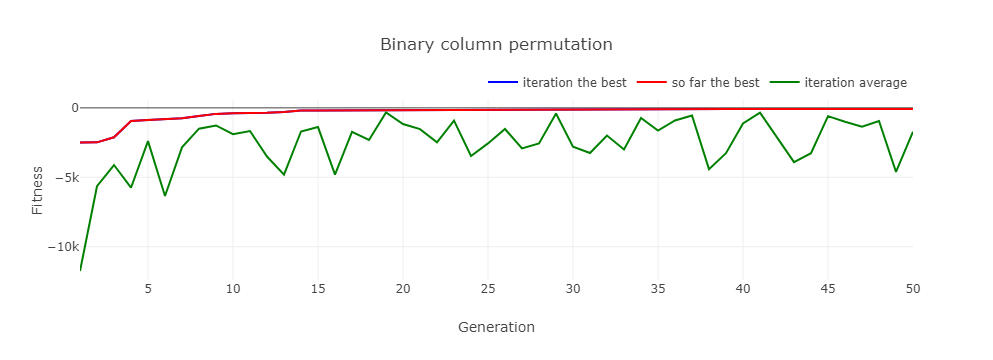

In [ ]:
ga_xyz.set_evole_record(ft_iteration_avg,ft_iteration_best,ft_so_far_the_best)
ga_xyz.plot_evole()

In [ ]:
fig.write_html(r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\GA evovle.html")

In [ ]:
sol = [i for i in range(0,len(ds.df_bin.columns[:-1]))]
sol

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26]

In [ ]:
min_type1_dis_fitness(sol,_)

-28.47599020145188

In [ ]:
max_ssb_ssw_fitness(sol,_)

4662.841899992229

In [ ]:
total_error = 0
for c in df_new_encode.columns:
    X,Y = list(df_0_new_encode[c]),list(df_1_new_encode[c])
    SST, SSE = sum([(t - np.mean(X+Y))**2 for t in X+Y]), sum([(x - np.mean(X))**2 for x in X])+sum([(y - np.mean(Y))**2 for y in Y])
    SSB = SST-SSE
    total_error += SSB
return total_error

### &emsp;| (2) encoding result

In [ ]:
ga_xyz.encode_categorical()

,z,y,x,GB
0,1,2,1,0
1,2,2,1,0
2,1,2,1,0
3,2,2,1,0
4,2,2,1,0
...,...,...,...,...
3295,1,2,1,1
3296,1,2,1,1
3297,1,2,1,1
3298,1,2,1,1


In [ ]:
out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output"
plot_comparsion_all_new(df_read, df_bin, ga_xyz.encode_categorical(), dr_name = "GA",sep=ga_xyz.Dataset.sep)

<_io.TextIOWrapper name="C:\\Users\\User\\Desktop\\Terry\\Data\\Output/['GA'].html" mode='a' encoding='cp1252'>

In [ ]:
plot_compare_all(ds_data, ga_xyz, dr_name = "GA")

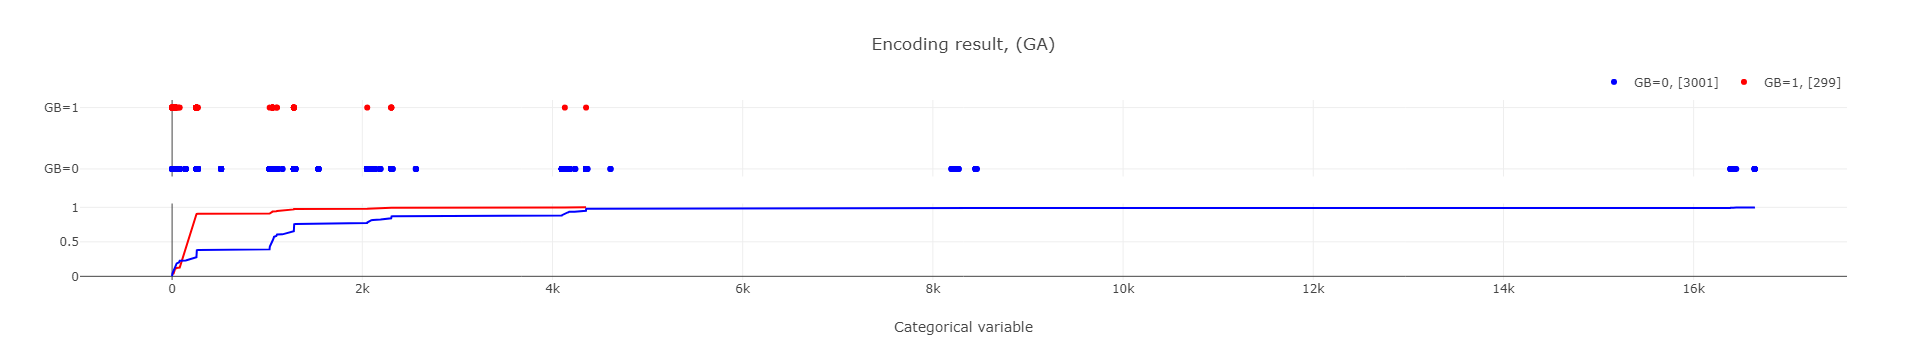

In [ ]:
df_ga = arrange_col_by_order(df_bin,[l_col[i] for i in list(ga_xyz.ga.best_solution()[0])])
plot_encode_axis(df_ga, "(GA)")

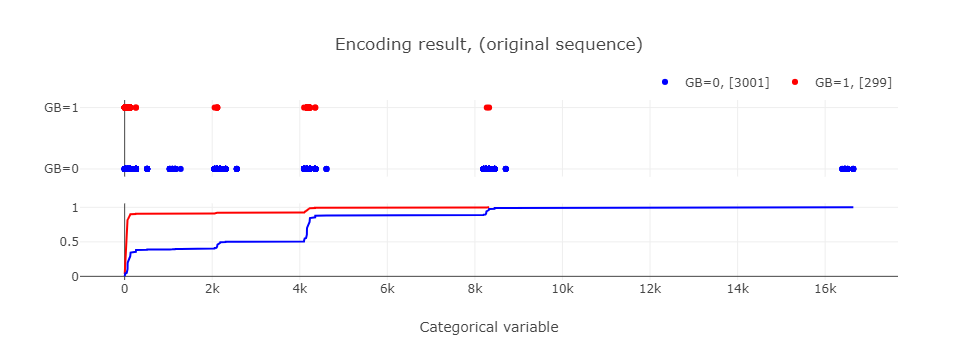

In [ ]:
df_ori = arrange_col_by_order(df_bin,df_bin.columns[:-1])
plot_encode_axis(df_ori, "(original sequence)")# df_new

## ***<span style='color:brown'>Defult class<span style='color:brown'>***

In [ ]:
### rnd
rnd_encoder = seq_encoder(gd_rnd, "rnd")
rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category)
rnd_encoder.encode_grid()

### sum
sum_encoder = seq_encoder(gd_xyz, "sum")
sum_encoder.set_encode_funs(seq_sum,sort_LargeToSmall,encode_category)
sum_encoder.encode_grid()

### id
gt_encoder = seq_encoder(gd_xyz, "ID")
gt_encoder.set_encode_funs(seq_ID,sort_SmallToLarge,encode_category)
gt_encoder.encode_grid()

### gini
gi_encoder = seq_encoder(gd_xyz,"gini")
gi_encoder.set_encode_funs(seq_ratio,sort_SmallToLarge,encode_category)
gi_encoder.encode_grid()

In [ ]:
plot_encode_axis(rnd_encoder)

AttributeError: 'seq_encoder' object has no attribute 'encode_cate'

In [ ]:
plot_encoded_axis(sum_encoder,sum_encoder.df_grid)

In [ ]:
# out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output\3D Fig"
plot_compare_all(ori_data,gd_rnd,sum_encoder,sum_encoder.df_grid_train)

NameError: name 'out_put_path' is not defined

# <mark>***Classification***</mark>
---

##### <center> <span style='color:gray'> import & class<span style='color:gray'> </center>

In [10]:
from sklearn.model_selection import train_test_split
from ipywidgets import Layout
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [11]:
class Data_classifier():
    def __init__(self,dict_df, name,) -> None:
        def overlap_transform(X_train,y_train):
            # X_train,y_train =x,y
            df, col_name, = X_train.copy(), y_train.copy().columns[-1]
            df[col_name]= y_train.copy()
            df_type1 = df.loc[df[col_name] == 1].drop_duplicates().drop(columns=[col_name],)
            new_y_train,l = [],[list(row) for row in df_type1.values]
            for row in X_train.values:
                if list(row) in l:new_y_train.append(1)
                else: new_y_train.append(0)
            return pd.DataFrame(data=new_y_train, columns=[col_name], index = y_train.index)

        self.name = name
        self.dict_df = dict_df.copy()
        
        ### prepare train and test
        X_train, y_train = self.dict_df["Train"].iloc[:,:-1], self.dict_df["Train"].iloc[:,-1:]
        X_test, y_test = self.dict_df["Test"].iloc[:,:-1], self.dict_df["Test"].iloc[:,-1:]

        # overlap trasform
        # y_train = overlap_transform(X_train,y_train)

        self.lgb_train = lgb.Dataset(data=X_train,label=y_train)
        self.lgb_test = lgb.Dataset(data=X_test,label=y_test)

    def set_classifier(self, params, rounds, feval):
        self.params = params
        self.rounds = rounds
        self.feval = feval
        self.evals_result = {}
        
    def run_classify(self,):
        def matrix_reflection(m):
            tl,tr = m[0][0], m[1][0]
            dl,dr = m[0][1],m[1][1]
            n = np.array([[dr, dl],[tr, tl]])
            return n

        def recall_precision_n(m):
            tp,fp = m[0][0], m[1][0]
            fn,tn = m[0][1],m[1][1]
            a = (tp+tn)/(tp+fp+fn+tn)
            p = np.sum(tp / (tp + fn))
            r = np.sum(tp / (tp + fp))
            f = (2 * p * r) / (r + p)
            return  dict(recall = r, precision = p, f1_score = f)

        self.clf = lgb.train(
        params = self.params,
        train_set = self.lgb_train, 
        num_boost_round = self.rounds,
        valid_sets = [ self.lgb_train, self.lgb_test], 
        valid_names = ["Train", "Validation"], 
        evals_result = self.evals_result, 
        early_stopping_rounds = None,
        feval=self.feval,)
        
        X_test, y_test = self.dict_df["Test"].iloc[:,:-1].copy(), self.dict_df["Test"].iloc[:,-1:].copy()
        y_pred_lgbm = self.clf.predict(X_test, num_iteration = self.clf.best_iteration)
        # convert into binary values
        for i in range(0, X_test.shape[0]):
            if y_pred_lgbm[i] > .5:y_pred_lgbm[i] = 1
            else:y_pred_lgbm[i] = 0
        # output confusion matris
        self.confusion_matrix = matrix_reflection(confusion_matrix(y_test, y_pred_lgbm))
        self.score = recall_precision_n(self.confusion_matrix)
        
    ### plot
    def plot_feature_importance(self,):
        # import plotly.plotly as py
        # from plotly.graph_objs import *
        feat_name ,feat_imp = self.clf.feature_name().copy(), self.clf.feature_importance().copy()
        feat_name = [x for _, x in sorted(zip(feat_imp, feat_name), reverse = False)]
        feat_imp.sort()
        fig = go.Figure()

        # M, m = max(feat_imp), min(feat_imp)
        # gap = int(int(M - m)/len(feat_imp))
        # if (M-m)<len(feat_imp):colors = [i for i in range(m, M, gap)]
        # else:colors = [i for i in range(m, M, gap)]

        fig.add_trace(go.Bar(x=feat_imp, y= feat_name, opacity=0.8,orientation='h', marker={"color":list(feat_imp),"colorscale": "Viridis", "reversescale": False}))
        fig.update_layout(
            title_text=f'Feature Importance<br><sup>  </sup> ', # title of plot
            barmode='group',
            modebar_orientation="h",
            yaxis=dict(position=0)#,tickfont = dict(size=20))
        )
        return fig 

    def plot_metric_in_training(self,):
        fig = go.Figure()
        evals = self.evals_result
        dict_eval  = evals.copy()
        metric = list(dict_eval[list(dict_eval.keys())[0]].keys())[0]
        rounds = [i for i in range(0,len(dict_eval[list(dict_eval.keys())[0]][metric]))]

        for name in dict_eval:
            fig.add_trace(go.Scatter(x=rounds, y=evals[name][metric],mode='lines',name=name))
        fig.update_layout(
            title_text=f'Metric during Training<br><sup>  </sup> ', # title of plot
            xaxis_title_text=f"Rounds", # yaxis label
            yaxis_title_text=metric, # yaxis label
            yaxis=dict(position=0)#,tickfont = dict(size=20))
        )
        fig.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1))
        return fig

    def plot_confusion_matrix(self,):
        cm = self.confusion_matrix.copy()
        fig = go.Figure()
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, text=cm,
         texttemplate="%{text}",showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig.add_trace(heatmap)
        fig.update_yaxes(showgrid=False,showticklabels=False,autorange='reversed')
        fig['layout']['yaxis'].update(showgrid=False,showticklabels=True,autorange='reversed')
        fig.update_xaxes(showgrid=False,showticklabels=True)    
        fig.update_layout(title = "Confusion Matrix", showlegend=True)
        return fig

    def plot_score(self,):
        dict_score = self.score.copy()
        fig = go.Figure()
        colors = ["blue","orange","green"]
        fig.add_trace(go.Bar(x=list(dict_score.keys()),y=list(dict_score.values()),name="",opacity=0.6,marker={"color":colors,}))
        fig.update_layout(
            title_text=f'Score <br><sup> </sup> ', # title of plot
            legend_tracegroupgap = 180,
            bargap=0.3, # gap between bars of adjacent location coordinates
            bargroupgap=0.1, # gap between bars of the same location coordinates      
        )
        return fig

    def plot_all(self,):
        fig = make_subplots(rows=2, cols=3,subplot_titles=["Feature Importance","Metric during training", "Confusion matrix", "Score"], column_widths = [0.5,0.25,0.25], 
        specs=[[{"rowspan": 2}, {"colspan":2}, None],
        [None, {}, {}]])

        ### metric during training
        evals = self.evals_result
        dict_eval  = evals.copy()
        metric = list(dict_eval[list(dict_eval.keys())[0]].keys())[0]
        rounds = [i for i in range(0,len(dict_eval[list(dict_eval.keys())[0]][metric]))]
        for name in dict_eval:
            fig.add_trace(go.Scatter(x=rounds, y=evals[name][metric],mode='lines',name=name), row = 1, col = 2)

        ### feature importance
        feat_name ,feat_imp = self.clf.feature_name().copy(), self.clf.feature_importance().copy()
        feat_name = [x for _, x in sorted(zip(feat_imp, feat_name), reverse = False)]
        feat_imp.sort()
        # M, m = max(feat_imp), min(feat_imp)
        # gap = int(int(M+1 - m)/len(feat_imp))
        # colors = [i for i in range(m, M, gap)]
        fig.add_trace(go.Bar(x=feat_imp, y= feat_name, opacity=0.8,orientation='h', marker={"color":list(feat_imp),"colorscale": "Viridis", "reversescale": False}, showlegend=False),row = 1, col = 1)

        ### confusion matrix
        cm = self.confusion_matrix.copy()
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, text=cm,
            texttemplate="%{text}",showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig.add_trace(heatmap,  row = 2, col = 2)

        ### score
        dict_score = self.score.copy()
        colors = ["blue","orange","green"]
        fig.add_trace(go.Bar(x=list(dict_score.keys()),y=list(dict_score.values()),name="",opacity=0.8,marker={"color":colors,}, showlegend=False),  row = 2, col = 3)

        fig.update_yaxes(showgrid=False,showticklabels=True,autorange='reversed', row=2, col=2)
        fig.update_layout(title_text=f'Classification result<br><sup>  </sup> ',
        legend=dict(orientation="h",yanchor="bottom",y=0.75,xanchor="right",x=1))

        buffer = io.StringIO()
        fig.write_html(buffer, full_html=False, include_plotlyjs='cdn')
        main_title = f'<div style="text-align:center;height: 10vh;"><h2 style="font-family:verdana;">'+ f"Classification result<br><sup> {self.name}</sup></br>"+ '</h2></div>'
        body = f'<div style="overflow-y:scroll;height: 90vh;">'+buffer.getvalue().encode().decode()+'</div>'
        return main_title+body



##### <center> <span style='color:gray'> feval functions <span style='color:gray'> </center>

In [14]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

feval_fun = None
def lgb_fbeta_score(y_hat, data):
    beta_value=sd_gbm_fbeta.value
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f'f {beta_value} ', fbeta_score(y_true, y_hat, beta = beta_value), True

def lgb_recall_score(y_hat, data):
    beta_value=sd_gbm_fbeta.value
    y_true = data.get_label()
    y_hat = np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f'f {beta_value} ', recall_score(y_true, y_hat), True

##### -classification

In [302]:
def matrix_reflection(m):
    tl,tr = m[0][0], m[1][0]
    dl,dr = m[0][1],m[1][1]
    n = np.array([[dr, dl],[tr, tl]])
    return n

def recall_precision_n(m):
    tp,fp = m[0][0], m[1][0]
    fn,tn = m[0][1],m[1][1]
    a = (tp+tn)/(tp+fp+fn+tn)
    p = np.sum(tp / (tp + fn))
    r = np.sum(tp / (tp + fp))
    f = (2 * p * r) / (r + p)
    return  dict(recall = r, precision = p, f1_score = f)

In [303]:
def overlap_transform(X_train,y_train):
    # X_train,y_train =x,y
    df, col_name, = X_train.copy(), y_train.copy().columns[-1]
    df[col_name]= y_train.copy()
    df_type1 = df.loc[df[col_name] == 1].drop_duplicates().drop(columns=[col_name],)
    new_y_train,l = [],[list(row) for row in df_type1.values]
    for row in X_train.values:
        if list(row) in l:new_y_train.append(1)
        else: new_y_train.append(0)
    return pd.DataFrame(data=new_y_train, columns=[col_name], index = y_train.index)

In [281]:
def cal_all_dfs(dict_train, dict_test):
    dict_cm,dict_eval,dict_clf = {},{},{}
    df_all = pd.DataFrame()
    for name_df in dict_train:
        s, dict_cm[name_df], dict_eval[name_df], dict_clf[name_df] = pre_and_cal_score(dict_train[name_df], dict_test[name_df])
        df_m = pd.DataFrame.from_dict(s, orient='index')
        df_m.columns = [name_df]
        df_all = pd.concat([df_all, df_m], axis=1)
    return df_all, dict_clf, dict_eval, dict_cm

def pre_and_cal_score(df_train, df_test): 
    X_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1:]
    X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1:]
    # X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1224, train_size = .75,stratify=y,)
    # overlap trasform
    y_train = overlap_transform(X_train,y_train)
    cm, evals_result, clf = light_gbm(X_train, X_test, y_train, y_test)
    cm_r = matrix_reflection(cm)
    # cm_r = cm
    return recall_precision_n(cm_r), cm_r, evals_result, clf

def light_gbm(X_train, X_test, y_train, y_test):
    lgb_train = lgb.Dataset(data=X_train,label=y_train)
    lgb_test = lgb.Dataset(data=X_test,label=y_test)

    evals_result = {} 
    clf = lgb.train(
        params = params,
        train_set = lgb_train, 
        num_boost_round = gbm_round,
        valid_sets = [lgb_train, lgb_test], 
        valid_names = ["Train", "Validation"], 
        evals_result = evals_result, 
        early_stopping_rounds = None,
        feval=feval_fun,
    )
    # prediction on test data
    y_pred_lgbm = clf.predict(X_test, num_iteration = clf.best_iteration)
    # convert into binary values
    for i in range(0, X_test.shape[0]):
        if y_pred_lgbm[i] > .5:y_pred_lgbm[i] = 1
        else:y_pred_lgbm[i] = 0
    # output confusion matris
    cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
    return cm_lgbm, evals_result, clf



##### -plot

In [282]:
def plot_heatmap_all(dict_cm):
    fig,ax=plt.subplots(1,len(dict_cm),figsize=(5*len(dict_cm), 5))

    # target = ['Ori','Mach','Mach_LS','Mach_SL','Cham','Cham_LS','Cham_SL']
    tick = ["GB=1","GB=0"]
    # for index, i in enumerate(target):
    x = 0
    for i in dict_cm:
        cm = dict_cm[i]
        sns.set(font_scale=1.8)
        sns.heatmap(cm, annot = True,xticklabels=tick,yticklabels=tick, fmt="", cbar=False,ax = ax[x])
        #, rc={'axes.facecolor':color, 'figure.facecolor':color} )
        ax[x].set_title(i)
        ax[x].get_xaxis().set_visible(True)
        if x != 0:
            ax[x].get_yaxis().set_visible(False)
        x = x+1
    p = [n for n in df_name.split('/')]
    plt.suptitle(f"{p[0]}, {p[1]}", fontsize=30, y = 1.1)
    return fig
    
def plot_learning_curve_all(dict_eval, metric=None):
    fig,ax=plt.subplots(1,len(dict_eval),figsize=(5*len(dict_eval), 5))
    # for index, i in enumerate(target):
    x = 0
    for i in dict_eval:
        lgb.plot_metric(dict_eval[i], title = i, ax = ax[x], metric = metric)
        ax[x].get_legend().remove()
        x = x+1
    x = 0
    lines = []
    labels = []
    axLine, axLabel = ax[0].get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)   
    fig.legend(lines, labels, loc = "upper left", ncol=len(dict_eval))
    fig.tight_layout()
    p = [n for n in df_name.split('/')]
    plt.suptitle(f"{p[0]}, {p[1]}", fontsize=30, y = 1.1)
    return fig


    

In [561]:
def plot_classification_score(opp, df_score, dict_cm):
    ### score
    fig_score = make_subplots(rows=2, cols=1, row_heights = [0.65,0.35],specs=[[{}],[{"type": "table"}]])
    df = df_score.T.copy()
    for col in df.columns:fig_score.add_trace(go.Bar(x=df.index,y=df[col],name=col,opacity=0.8),row = 1, col = 1)
    df = df_score.copy()
    s_color = ['blue', 'orange', 'green']
    table = go.Table(ids=df.index,
        header=dict(values = df.columns.tolist(),fill_color='cornflowerblue',align='center',font=dict(color='white',size=15)),
        cells=dict(values = [df[c].values for c in df.columns],fill_color='ivory',align='center',font=dict(size=12, color = [s_color*len(df.columns)])))
    fig_score.add_trace(table,row=2,col=1)
    fig_score.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)) # title of plotlegend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1),)

    buffer = io.StringIO()
    fig_score.write_html(buffer, full_html=False, include_plotlyjs='cdn')
    html_score = f'<div style="height: 70vh;">'+buffer.getvalue().encode().decode()+'</div>'

    ### cm
    fig_cm = make_subplots(rows=1, cols=len(dict_cm))#,subplot_titles=(list(dict_cm.keys())))
    for i in range(0,len(dict_cm)):
        cm = dict_cm[list(dict_cm.keys())[i]]
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, 
                             text=cm, texttemplate="%{text}",textfont={"size":10},
                             showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig_cm.add_trace(heatmap,row=1, col=i+1)
    fig_cm.update_yaxes(showgrid=False,showticklabels=False,autorange='reversed')
    fig_cm['layout']['yaxis'].update(showgrid=False,showticklabels=True,autorange='reversed')
    fig_cm.update_xaxes(showgrid=False,showticklabels=True)
    fig_cm.update_layout(title = "LightGBM Classification result ", showlegend=True,height=300,)

    buffer = io.StringIO()
    fig_cm.write_html(buffer, full_html=False, include_plotlyjs='cdn')
    html_cm = f'<div style="height: 30vh;">'+buffer.getvalue().encode().decode()+'</div>'


    html_all = html_cm + html_score
    html_all = f'<div style="height: 100vh;">'+html_all+'</div>'
    if os.path.exists(f"{opp}/Classification results.html"): os.remove(f"{opp}/Classification results.html")
    with open(f"{opp}/Classification results.html", 'a') as f:
        f.write(html_all)

In [ ]:
def plot_class_score(df_data):
    global df_name
    df_name = f"{shp_name} / Binary Features: {n_bin_col}"
    df = df_data.T.copy()
    fig = go.Figure()
    for col in df.columns:
        fig.add_trace(go.Bar(x=df.index,y=df[col],name=col,opacity=0.8))
    fig.update_layout(
        title_text=f'LightGBM Classification result <br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text='score', # yaxis label
        barmode='group',
        legend_tracegroupgap = 180,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height=500,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    return fig

def plot_class_cm(dict_cm):
    fig = make_subplots(rows=1, cols=len(dict_cm),subplot_titles=(list(dict_cm.keys())))
    for i in range(0,len(dict_cm)):
        cm = dict_cm[list(dict_cm.keys())[i]]
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, 
                             text=cm, texttemplate="%{text}",textfont={"size":10},
                             showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig.add_trace(heatmap,row=1, col=i+1)

    fig.update_yaxes(showgrid=False,showticklabels=False,autorange='reversed')
    fig['layout']['yaxis'].update(showgrid=False,showticklabels=True,autorange='reversed')
    fig.update_xaxes(showgrid=False,showticklabels=True)    
    fig.update_layout(title = "Confusion Matrix", showlegend=True,height=300,)
    return fig

def plot_class_score_table(df_data):
    # df = df_data.copy().applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
    df = df_data.copy()
    s_color = ['blue', 'orange', 'green']
    fig = go.Figure(data=[go.Table(ids=df.index,
    header=dict(values = df.columns.tolist()
                ,fill_color='cornflowerblue',align='center',
                font=dict(color='white',size=15)),
    cells=dict(values = [df[c].values for c in df.columns]
               ,fill_color='ivory',align='center'
               ,font=dict(size=12, color = [s_color*len(df.columns)])))])
    fig.update_layout(height = 130,margin=go.layout.Margin(t=0, b=0))
    return fig

def plot_class_all(df_score, dict_cm):
    fig_sc = plot_class_score(df_score.copy())
    fig_cm = plot_class_cm(dict_cm.copy())
    fig_tb = plot_class_score_table(df_score.copy())
    # output fig, create path if not exist
    if not os.path.exists(out_put_path): os.makedirs(out_put_path)
    # check output name, delete file if exist
    p = ["Classification results"]
    if os.path.exists(f"{out_put_path}/{p}.html"): os.remove(f"{out_put_path}/{p}.html")
    # df_name = f"{shp_name} / SP {sliced_part} / {select_group} /{m_name}"
    with open(f"{out_put_path}/{p}.html", 'a') as f:
        f.write(fig_sc.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_tb.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_cm.to_html(full_html=False, include_plotlyjs='cdn'))

##### <center> <span style='color:gray'> params settings <span style='color:gray'> </center>

In [16]:
### UI event
gbm_metric = "average_precision"
gbm_boost_type = "gbdt"
gbm_feval = True
gbm_round = 500
def rb_event_gbm_metric(sender):
    global gbm_metric   
    gbm_metric = rb_gbm_metric.value
def rb_event_gbm_boost_type(sender):
    global gbm_boost_type   
    gbm_boost_type = rb_gbm_boost_type.value  
def rb_event_gbm_feval(sender):
    global gbm_feval   
    tp = rb_gbm_feval.value
    if tp == "on":
        gbm_feval = True
    elif tp == "off":
        gbm_feval = False

### UI outlook
rb_gbm_boost_type = widgets.RadioButtons(
    options=["gbdt", "dart", "rf","goss"],
    layout={'width': 'max-content'},
)
rb_gbm_metric = widgets.RadioButtons(
    options=["average_precision", "auc", "rmse","binary_logloss","None"],
    layout={'width': 'max-content'},
)
rb_gbm_feval = widgets.RadioButtons(
    options=["on", "off"],
    layout={'width': 'max-content'},
)
sd_gbm_fbeta = widgets.FloatSlider(value = 0.5, min = 0.0, max = 1.0, step = 0.1,description='',layout=Layout(width='200px'))
sd_gbm_round = widgets.IntSlider(value = 300, min = 100, max = 1000, step = 100,description='',layout=Layout(width='300px'))
rb_gbm_boost_type.observe(rb_event_gbm_boost_type, names=['value'])
rb_gbm_metric.observe(rb_event_gbm_metric, names=['value'])
rb_gbm_feval.observe(rb_event_gbm_feval, names=['value'])

In [17]:
vb_metiric = VBox([Button(description="metric"), rb_gbm_metric])
vb_boost_type = VBox([Button(description="boost type"), rb_gbm_boost_type])
vb_feval = VBox([Button(description="feval",layout=Layout(width='200px')), rb_gbm_feval,Button(description="beta",layout=Layout(width='200px')),sd_gbm_fbeta])
vb_boost_round=VBox([Button(description="boosting rounds",layout=Layout(width='300px')), sd_gbm_round])

display(HBox([vb_boost_type,vb_metiric, vb_feval,vb_boost_round]))

In [18]:
params = {
        "objective": "binary",
        "metric": gbm_metric,
        "verbosity": -1,
        "boosting_type": gbm_boost_type,                
        "seed": 1224,
    }
if gbm_feval: feval_fun = lgb_recall_score
gbm_round =  sd_gbm_round.value

In [ ]:
%%capture
### data
encoder = gi_encoder
dict_df = encoder.dict_df["Encode"]

### create
clf_data = Data_classifier(dict_df,encoder.name)

### set clf
clf_data.set_classifier(params,gbm_round,feval_fun)

### run clf
clf_data.run_classify()

## ii. classify by lightgbm

In [ ]:
df_train,df_test = dict_train["Bin"],dict_test["Bin"]
X_train, y_train = df_train.iloc[:,:-1], df_train.iloc[:,-1:]
X_test, y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1:]
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1224, train_size = .75,stratify=y,)
# overlap trasform
y_train = overlap_transform(X_train,y_train)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
%%capture
df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_df)

NameError: name 'dict_df' is not defined

In [ ]:
df_all=df_all.fillna(0)
df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
df_all

,binary,original,GA
recall,0.72,0.72,0.72
precision,0.806,0.806,0.806
f1_score,0.761,0.761,0.761


In [ ]:
out_put_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\BC"
plot_class_all(df_all, dict_cm)

In [ ]:
df_name = f"{shp_name} / SP {sliced_part}"

if gbm_metric == "None": plot_learning_curve_all(dict_eval).show()
else: plot_learning_curve_all(dict_eval,gbm_metric).show()
plot_heatmap_all(dict_cm).show()

## * different BC test* with GA

In [ ]:
%%capture
shp_name = "shape 3"
ori_data = Originl_Data(shp_name)
f1_score, re_score, pre_score = {},{},{}
R = range(30,103,3)
SKFold = 4
for bc in R:
    # 1. read and slice data
    #........................................................
    ori_data.slice_to_bin(bc)
    ori_data.drop_zero_col()
    ori_data.drop_one_col_minsum()
    ori_data.get_sep_and_col()
    ori_data.spilt_SKFold(SKFold)
    fold_f1, fold_re, fold_pre = [],[],[]
    for fold in range(0,SKFold):
        ori_data.set_folds(fold)
        # ori_data.spilt_train_and_test(0.75)
        out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})\fold {fold+1}"

        # 2. group columns
        #........................................................
        ### xyz
        gd_xyz = Grouped_Data(ori_data,"xyz")
        gd_xyz.set_seq([i for i in range(0,ori_data.bin_feat)])
        gd_xyz.set_col(["x","y","z"])
        gd_xyz.group_df()
        # ### rnd
        # gd_rnd = Grouped_Data(ori_data,"Rnd")
        # gd_rnd.set_seq(random.sample([i for i in range(0, ori_data.bin_feat)],ori_data.bin_feat))
        # gd_rnd.set_col(["r1","r2","r3"])
        # gd_rnd.group_df()
        # ### pca
        # gd_pca = Grouped_Data_PCA(ori_data,"PCA")
        # gd_pca.set_seq()
        # gd_pca.set_col(["pc1","pc2","pc3"])
        # gd_pca.group_df()
        ### corr
        gd_corr = Grouped_Data_Corr(ori_data, "corr")
        gd_corr.set_seq()
        gd_corr.set_col(["c1","c2","c3"])
        gd_corr.group_df()
        
        gd_corrABS = Grouped_Data_Corr_ABS(ori_data, "corr ABS")
        gd_corrABS.set_seq()
        gd_corrABS.set_col(["c1","c2","c3"])
        gd_corrABS.group_df()        
        
        gd_corrSqure = Grouped_Data_Corr_Squre(ori_data, "corr squre")
        gd_corrSqure.set_seq()
        gd_corrSqure.set_col(["c1","c2","c3"])
        gd_corrSqure.group_df()      
        
        dict_gd = {}
        # dict_gd = {"xyz":gd_xyz,"Rnd":gd_rnd,"PCA":gd_pca, "Corr":gd_corr}
        dict_gd = {"xyz":gd_xyz,"Corr":gd_corr, "Corr ABS":gd_corrABS, "Corr Squre":gd_corrSqure}
        # 3. encoding
        #........................................................
        dict_train, dict_test = {}, {}
        dict_train["Bin"], dict_test["Bin"] = ori_data.df_train, ori_data.df_test
        for name_gd in dict_gd:
            paths = []
            group_data = dict_gd[name_gd]
    #         for f in [" "]:#, "SSB, SSE"]: 
    #             ft_iteration_avg, ft_iteration_best, ft_so_far_the_best=[],[],[]

    #             ### GA
    #             gd_fit = gd
    #             ga_encoder = GA_encoder(gd, f"{name_gd} / GA {f}" )
    #             if f ==" ":fitness_func = min_type1_dis_fitness
    #             else :fitness_func = max_ssb_ssw_fitness
    #             ga_encoder.bulid_ga(sol_per_pop=30, num_generations=100,fitness_func = fitness_func)
    #             ga_encoder.run_ga()
    #             ga_encoder.set_evole_record(ft_iteration_avg,ft_iteration_best,ft_so_far_the_best)

    #             path = plot_compare_all(ori_data, ga_encoder, ga_encoder.encode_grid(),ga_encoder.reindex_encoded())
    #             with open(path, 'a') as file:file.write(ga_encoder.plot_evole().to_html(full_html=False, include_plotlyjs='cdn'))
    #             paths.append(path)
    #             dict_df[f"{ga_encoder.name}"] = ga_encoder.reindex_encoded()
    #             # dict_df[f"{ga_encoder.name} / grid"] = ga_encoder.rerange_grid()

            ### ground truth  
            if name_gd =="xyz":
                gt_encoder = seq_encoder(group_data,f"{name_gd} / ID" )
                gt_encoder.set_encode_funs(seq_ID,sort_LargeToSmall,encode_category)       
                gt_encoder.encode_grid()
                paths.append(plot_compare_all(ori_data, group_data, gt_encoder, gt_encoder.df_grid))
                dict_train[f"{gt_encoder.name}"],dict_test[f"{gt_encoder.name}"] = gt_encoder.df_grid_train, gt_encoder.df_grid_test
            ### sum 
            sum_encoder = seq_encoder(group_data,f"{name_gd} / Sum")
            sum_encoder.set_encode_funs(seq_sum,sort_SmallToLarge,encode_category)       
            sum_encoder.encode_grid()
            paths.append(plot_compare_all(ori_data, group_data, sum_encoder, sum_encoder.df_grid))
            dict_train[f"{sum_encoder.name}"],dict_test[f"{sum_encoder.name}"] = sum_encoder.df_grid_train,sum_encoder.df_grid_test

            ### gini
            gi_encoder = seq_encoder(group_data,f"{name_gd} / gini")
            gi_encoder.set_encode_funs(seq_ratio,sort_SmallToLarge,encode_category)
            gi_encoder.encode_grid()
            paths.append(plot_compare_all(ori_data, group_data, gi_encoder, gi_encoder.df_grid))
            dict_train[f"{gi_encoder.name}"],dict_test[f"{gi_encoder.name}"] = gi_encoder.df_grid_train, gi_encoder.df_grid_test

            ### rnd  
            rnd_encoder = seq_encoder(group_data,f"{name_gd} / Rnd" )
            rnd_encoder.set_encode_funs(seq_rnd,sort_LargeToSmall,encode_category) 
            rnd_encoder.encode_grid()
            paths.append(plot_compare_all(ori_data, group_data, rnd_encoder, rnd_encoder.df_grid))
            dict_train[f"{rnd_encoder.name}"],dict_test[f"{rnd_encoder.name}"] = rnd_encoder.df_grid_train,rnd_encoder.df_grid_test

            if name_gd == "PCA": 
                for p in paths:
                    with open(p, 'a') as file:file.write(group_data.plot_pca_group().to_html(full_html=False, include_plotlyjs='cdn'))
            elif name_gd == "Corr": 
                for p in paths:
                    with open(p, 'a') as file:file.write(group_data.plot_corr_group().to_html(full_html=False, include_plotlyjs='cdn'))
    
        # 4. Classification
        #........................................................
        df_all, dict_clf, dict_eval, dict_cm =  cal_all_dfs(dict_train, dict_test)
        df_all=df_all.fillna(0)
        df_all = df_all.applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,4)))
        fold_f1.append(list(np.concatenate(df_all.loc[["f1_score"]].values).flat)) 
        fold_re.append(list(np.concatenate(df_all.loc[["recall"]].values).flat))
        fold_pre.append(list(np.concatenate(df_all.loc[["precision"]].values).flat))
        plot_class_all(df_all, dict_cm, bc)
        
    f1_score[f"bc {bc}"] = np.mean(np.array(fold_f1).astype(np.float) , axis = 0)
    re_score[f"bc {bc}"] = np.mean(np.array(fold_re).astype(np.float) , axis = 0)
    pre_score[f"bc {bc}"] = np.mean(np.array(fold_pre).astype(np.float) , axis = 0)
    out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})"
    # plot_class_all(df_all, dict_cm, bc)

In [ ]:
# output class score
score = re_score
df_class = pd.DataFrame(score).T
df_class.columns = df_all.columns
df_class.index = [idx.split(" ")[1] for idx in list(df_class.index)]
df_class = df_class.round(decimals = 4)
df_class.index.name = "Binary features"
df_class

,Bin,xyz / ID,xyz / Sum,xyz / gini,xyz / Rnd,Corr / Sum,Corr / gini,Corr / Rnd,Corr ABS / Sum,Corr ABS / gini,Corr ABS / Rnd,Corr Squre / Sum,Corr Squre / gini,Corr Squre / Rnd
Binary features,,,,,,,,,,,,,,
30,0.9264,0.6824,0.6598,0.5798,0.4351,0.8864,0.8797,0.3738,0.6598,0.5730,0.2502,0.9264,0.9264,0.3840
33,0.8897,0.7692,0.7288,0.8023,0.5579,0.8428,0.8629,0.2969,0.7288,0.8023,0.5548,0.8255,0.8356,0.6179
36,0.8929,0.6029,0.7696,0.7796,0.6429,0.8130,0.8259,0.2243,0.8329,0.8229,0.5929,0.8329,0.8229,0.5453
39,0.8996,0.6472,0.7319,0.8021,0.5708,0.8628,0.8963,0.2110,0.8252,0.8321,0.6002,0.8252,0.8321,0.5168
42,0.8694,0.5991,0.3951,0.5087,0.1705,0.8260,0.8194,0.2175,0.7118,0.7487,0.2470,0.7861,0.8028,0.2034
45,0.8496,0.7228,0.6193,0.5617,0.3371,0.7725,0.7363,0.1203,0.7557,0.7355,0.0606,0.8496,0.8263,0.3606
48,0.8796,0.6395,0.7619,0.7384,0.3942,0.7286,0.7484,0.1709,0.8119,0.7984,0.4722,0.8119,0.7984,0.3925
51,0.8494,0.4527,0.4894,0.6061,0.1612,0.7890,0.6853,0.1207,0.8494,0.7224,0.1607,0.8461,0.7224,0.4116
54,0.8327,0.4640,0.5379,0.4983,0.3033,0.6623,0.6588,0.0834,0.8294,0.7088,0.2600,0.8294,0.6988,0.3248


In [ ]:
df = df_class
metric = "recall"
fig_line = plot_class_score_line(df.T, metric)
fig_bar = plot_class_score_bar(df.T, metric)

In [ ]:
shp_name = "shape 5"
file_name = "10-4 score.xlsx"
path = rf"C:\Users\User\Desktop\Terry\Data\Datasets\{file_name}"
df_score = pd.read_excel(path,index_col=0,sheet_name = shp_name)
metric = []
n = int(len(df_score.columns)/2)
for i in range(0,2):
    df = df_score.iloc[:,i*n:i*n+n]
    metric.append(df.columns[0])
new_header = df_score.iloc[0] 
df_score = df_score[1:]
df_score.columns = new_header 

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\User\\Desktop\\Terry\\Data\\Datasets\\10-4 score.xlsx'

In [ ]:
df_score

Binary Features,\nBin,xyz / ID,xyz / Sum,xyz / gini,xyz / Rnd,Rnd / Sum,Rnd / gini,Rnd / Rnd,PCA / Sum,PCA / gini,...,xyz / Rnd,Rnd / Sum,Rnd / gini,Rnd / Rnd,PCA / Sum,PCA / gini,PCA / Rnd,Corr / Sum,Corr / gini,Corr / Rnd
30,0.9867,0.9867,0.9867,0.9867,0.9867,0.9867,0.9867,0.08,0.9867,0.9867,...,0.2691,0.2721,0.302,0.0779,0.2731,0.2691,0.2857,0.2824,0.2937,0.2877
33,0.8933,0.8933,0.8933,0.8933,0.8933,0.8933,0.8933,0,0.8933,0.8933,...,0.3401,0.3401,0.3454,0,0.3472,0.3418,0.3333,0.3333,0.3333,0.4342
36,0.9467,0.7467,0.7867,0.24,0.0133,0.9467,0.9467,0,0.9333,0.9467,...,0.0185,0.343,0.3397,0,0.3349,0.3302,0.3178,0.3532,0.3698,0.2308
39,0.8933,0.7333,0.6667,0.6667,0.72,0.8933,0.8933,0.24,0.8933,0.9333,...,0.4954,0.3622,0.3526,0.1667,0.3829,0.3867,0.2569,0.3384,0.3367,0.0889
42,0.84,0.6533,0.68,0.48,0,0.8267,0.8267,0.04,0.8267,0.84,...,0,0.4026,0.4161,0.075,0.4247,0.3865,0.4397,0.4189,0.3827,0.3514
45,0.8667,0.64,0.88,0.8267,0.0667,0.8667,0.8533,0.5733,0.8667,0.8667,...,0.125,0.4194,0.4354,0.5658,0.4221,0.4194,0.0682,0.4167,0.4422,0.2045
48,0.8667,0.6133,0.48,0.4267,0,0.8667,0.8667,0.1333,0.8667,0.8667,...,0,0.4643,0.5417,0.2439,0.4779,0.5372,0.3256,0.5159,0.4815,0.4194
51,0.8933,0.1733,0.8667,0.84,0.0133,0.8933,0.88,0.04,0.8933,0.8933,...,0.0667,0.5154,0.4853,0.1429,0.5,0.4718,0.0833,0.5276,0.5038,0.4286
54,0.8,0.56,0.6667,0.6267,0,0.8,0.8,0,0.8133,0.8,...,0,0.5042,0.5128,0,0.5169,0.5,0.0588,0.5172,0.4615,0.4643
57,0.84,0.28,0.8533,0.8533,0,0.84,0.8533,0,0.8533,0.84,...,0,0.5431,0.5289,0,0.5872,0.5676,0.359,0.5378,0.5431,0


In [ ]:
df_recall = df_score.iloc[:,0:n]
df_precision = df_score.iloc[:,n:n*2]

In [246]:
# df_data = pd.DataFrame(df_score.mean())
def plot_class_score_bar(df_score, metric):
    df_name = f"{shp_name}"
    df = pd.DataFrame(df_score.mean()).copy()
    fig = go.Figure()

    x = [[c.split("/")[0] for c in list(df.index)],
        [c for c in list(df.index)]]

    colors = ["#4c92c3","#ff993e","#56b356", "#de5253","#a985ca","#a3786f","#e992ce","#9e9e9e","#c9ca4e","#45cbd9", "#333333"]

    for i, col in enumerate( df.columns):
        fig.add_trace(go.Bar(x=x, y=df[col], name=col, opacity=0.8,  marker_color=colors))
    fig.update_layout(
        title_text=f'Average {metric} <br><sup> {df_name} </sup> ', # title of plot
        yaxis_title_text=f"{metric}", # yaxis label
        barmode='group',
        legend_tracegroupgap = 180,
        bargap=0.3, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates      
        height = 600,
        # legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
    )

    return fig

In [247]:
def plot_class_score_line(df_data, metric):
    global df_name
    df_name = f"{shp_name}"
    df = df_data.T.copy()
    fig = go.Figure()
    colors = ["#4c92c3","#ff993e","#56b356", "#de5253","#a985ca","#a3786f","#e992ce","#9e9e9e","#c9ca4e","#45cbd9", "#333333"]
    for i, col in enumerate( df.columns):
        fig.add_trace(go.Scatter(x=df.index,y=df[col],name=col,opacity=0.8))#,  line_color=colors[i]))
    fig.update_layout(
        title_text=f'Classification result <br><sup> {df_name} / {metric} </sup> ', # title of plot
        yaxis_title_text=f"{metric}", # yaxis label
        xaxis_title_text='Binary Features', # yaxis label
        legend_tracegroupgap = 180,
        height = 600
    )
    
    return fig

In [260]:
def plot_df_class_score_all(df_score, metric, shp_name, fig_name):
    def plot_df_class_score(df_score, metric, shp_name):
        df = df_score.copy()
        fig_line = go.Figure()
        # fig = make_subplots(rows=2, cols=1,subplot_titles=([f"Score under different BC",f"Average score"]))
        colors = ["#4c92c3","#780e27","#af2b25", "#c4664b","#e1a18b","#79823a","#a2ad67","#d0d3a4","#542787","#8173a8", "#b0abd0","#139654","#58af64","#a5daa2"]
        for i, col in enumerate( df.columns):
            fig_line.add_trace(go.Scatter(x=df.index,y=df[col],name=col,opacity=0.8, line_color=colors[i]))#,row=1, col=1)
            
        fig_bar = go.Figure()
        df =pd.DataFrame(df_score.copy().mean())
        x = [[c.split("/")[0] for c in list(df.index)],
            [c for c in list(df.index)]]
        for i, col in enumerate( df.columns):
            fig_bar.add_trace(go.Bar(x=x, y=df[col], name=col, opacity=0.8,  marker_color=colors))#,row=2, col=1)

        fig_line.update_layout(
            title_text=f'Score under different BC<br><sup> {shp_name} / {metric} </sup> ', # title of plot
            yaxis_title_text=f"{metric}", # yaxis label
            xaxis_title_text=f"Binary Features",
        )
        fig_bar.update_layout(
            title_text=f'Average score<br><sup> {shp_name} / {metric} </sup> ', # title of plot
            yaxis_title_text=f"{metric}", # yaxis label
        )
        return fig_line,fig_bar
    fig_line,fig_bar = plot_df_class_score(df_score, metric, shp_name)
    fig_path = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{fig_name}, {shp_name}, {metric}.html"
    if os.path.exists(f"{fig_path}"): os.remove(f"{fig_path}")
    with open(fig_path, 'a') as f:
        f.write(fig_line.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_bar.to_html(full_html=False, include_plotlyjs='cdn'))

In [ ]:
plot_df_class_score_all(df_class, "precision", shp_name, file_name)

In [ ]:
plot_df_class_score_all(df_class, "recall", shp_name,file_name)

In [ ]:
f1,f2 = plot_df_class_score(df_class,"recall","shape 5")

# <mark>***Run dataset***</mark>
---

In [19]:
import io
from io import StringIO

# group , encoder = gd_xyz, gi_encoder
# out_put_path = r"C:\Users\User\Desktop\Terry\Data\Output"

def plot_group_and_encode(opp, group , encoder):
    if not os.path.exists(opp): os.makedirs(opp)
    p = encoder.name.split("/ ")[1:][0] + encoder.name.split("/ ")[1:][1]
    if os.path.exists(f"{opp}/{p}.html"): os.remove(f"{opp}/{p}.html")
    with open(f"{opp}/{p}.html", 'a') as f:
        f.write(group.plot_column_group())
        if hasattr(group, 'plot_pca_group'):f.write(group.plot_pca_group())
        if hasattr(group, 'plot_corr_group'):f.write(group.plot_corr_group())
        f.write(encoder.plot_encoded_axis())
        f.write(encoder.plot_encoded_corr())
        dict_name = {"Categorical","OneHot","Encode"}
        for name in dict_name:f.write(plot_facets(encoder.dict_df[name], name))

def plot_facets_for_other_encoding(opp,ori_data):
    list_name = list(ori_data.dict_df.keys())[2:]
    for name in list_name:
        p = name
        if not os.path.exists(opp): os.makedirs(opp)
        with open(f"{opp}/{p}.html", 'a') as f:
            f.write(plot_facets(ori_data.dict_df["Categorical"], "Categorical"))
            f.write(plot_facets(ori_data.dict_df[name], name))

def plot_classifier(opp, clf):
    if "/" in clf.name:p = clf.name.split("/ ")[1:][0] +clf.name.split("/ ")[1:][1]
    else: p = clf.name
    if not os.path.exists(opp): os.makedirs(opp)
    # output
    with open(f"{opp}/{p}.html", 'a') as f:
        f.write(clf.plot_all())


In [20]:
def plot_classification_score(opp, df_score, dict_cm):
    ### score
    fig_score = make_subplots(rows=2, cols=1, row_heights = [0.65,0.35],specs=[[{}],[{"type": "table"}]])
    df = df_score.T.copy()
    for col in df.columns:fig_score.add_trace(go.Bar(x=df.index,y=df[col],name=col,opacity=0.8),row = 1, col = 1)
    df = df_score.copy()
    s_color = ['blue', 'orange', 'green']
    table = go.Table(ids=df.index,
        header=dict(values = df.columns.tolist(),fill_color='cornflowerblue',align='center',font=dict(color='white',size=15)),
        cells=dict(values = [df[c].values for c in df.columns],fill_color='ivory',align='center',font=dict(size=12, color = [s_color*len(df.columns)])))
    fig_score.add_trace(table,row=2,col=1)
    fig_score.update_layout(legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)) # title of plotlegend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1),)

    buffer = io.StringIO()
    fig_score.write_html(buffer, full_html=False, include_plotlyjs='cdn')
    html_score = f'<div style="height: 70vh;">'+buffer.getvalue().encode().decode()+'</div>'

    ### cm
    fig_cm = make_subplots(rows=1, cols=len(dict_cm))#,subplot_titles=(list(dict_cm.keys())))
    for i in range(0,len(dict_cm)):
        cm = dict_cm[list(dict_cm.keys())[i]]
        heatmap = go.Heatmap(x = ["GB = 1","GB = 0"],y = ["GB = 1","GB = 0"], z = cm, 
                             text=cm, texttemplate="%{text}",textfont={"size":10},
                             showscale=False,xgap=3, ygap=3,colorscale='RdBu')
        fig_cm.add_trace(heatmap,row=1, col=i+1)
    fig_cm.update_yaxes(showgrid=False,showticklabels=False,autorange='reversed')
    fig_cm['layout']['yaxis'].update(showgrid=False,showticklabels=True,autorange='reversed')
    fig_cm.update_xaxes(showgrid=False,showticklabels=True)
    fig_cm.update_layout(title = "LightGBM Classification result ", showlegend=True,height=300,)

    buffer = io.StringIO()
    fig_cm.write_html(buffer, full_html=False, include_plotlyjs='cdn')
    html_cm = f'<div style="height: 30vh;">'+buffer.getvalue().encode().decode()+'</div>'


    html_all = html_cm + html_score
    html_all = f'<div style="height: 100vh;">'+html_all+'</div>'
    if not os.path.exists(opp): os.makedirs(opp)
    if os.path.exists(f"{opp}/-Classification results.html"): os.remove(f"{opp}/-Classification results.html")
    with open(f"{opp}/-Classification results.html", 'a') as f:
        f.write(html_all)

In [ ]:
def classify_dict_df(dict_df,params,gbm_round,feval_fun):
    dict_dc = {}
    for i,name in enumerate(dict_df):
        dict_dc[name] = Data_classifier(dict_df[name],name)
        dict_dc[name].set_classifier(params,gbm_round,feval_fun)
        dict_dc[name].run_classify()
    return dict_dc
def get_df_score(dict_dc):
    df_score = pd.DataFrame(columns=dict_dc.keys())
    for col in df_score:
        df_score[col] = list(dict_dc[col].score.values())
    df_score.index = dict_dc[col].score.keys()

    sep = df_score.columns[-1].split("/")[0]+"/"
    df_score.columns = [c.replace(sep,"") for c in df_score.columns]
    return df_score
def get_list_cm(dict_dc):
    dict_cm = {}
    for k in dict_dc:
        dict_cm[k] = dict_dc[k].confusion_matrix
        # print(dict_dc[k].confusion_matrix)
    return dict_cm
    

In [21]:
def plot_fold_score(df_score, df_std, name, SKFold, opp):
    def plot_fold_score_bar(df_data, name, SKFold):
        # global df_name
        df = df_data.T.copy()
        fig = go.Figure()
        x = [[c.split("/")[0] for c in list(df.index)],[c for c in list(df.index)]]
        for col in df.columns:
            fig.add_trace(go.Bar(x=x,y=df[col],name=col,opacity=0.8))
        fig.update_layout(
            title_text=f'LightGBM Classification result <br><sup> {name}/{SKFold}-folds </sup> ', # title of plot
            yaxis_title_text='score', # yaxis label
            barmode='group',
            legend_tracegroupgap = 200,
            bargap=0.3, # gap between bars of adjacent location coordinates
            bargroupgap=0.1, # gap between bars of the same location coordinates      
            height=600,
            legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
        )
        return fig
    def plot_fold_std_bar(df_data,SKFold):
        # global df_name
        df = df_data.T.copy()
        fig = go.Figure()
        x = [[c.split("/")[0] for c in list(df.index)],[c for c in list(df.index)]]
        # colors = ["blue","red","yellow"]
        for col in df.columns:
            fig.add_trace(go.Bar(x=x,y=df[col],name=col,opacity=0.8))#,  marker_color=colors))
        fig.update_layout(
            title_text=f'standard deviation of {SKFold}-fold <br><sup> </sup> ', # title of plot
            yaxis_title_text='std', # yaxis label
            barmode='group',
            legend_tracegroupgap = 300,
            bargap=0.3, # gap between bars of adjacent location coordinates
            bargroupgap=0.1, # gap between bars of the same location coordinates      
            height=400,
            legend=dict(orientation="h",yanchor="bottom",y=1.02,xanchor="right",x=1)
        )
        return fig
    def plot_fold_score_table(df_data):
        # df = df_data.copy().applymap(lambda x: str(int(x)) if abs(x - int(x)) < 1e-6 else str(round(x,3)))
        df = df_data.copy()
        s_color = ['blue', 'orange', 'green']
        fig = go.Figure(data=[go.Table(ids=df.index,
        header=dict(values = df.columns.tolist()
                    ,fill_color='cornflowerblue',align='center',
                    font=dict(color='white',size=15)),
        cells=dict(values = [df[c].values for c in df.columns]
                ,fill_color='ivory',align='center'
                ,font=dict(size=12, color = [s_color*len(df.columns)])))])
        fig.update_layout(height = 130,
                        margin=go.layout.Margin(t=0, b=0)
                        )
        return fig
    
    fig_sc = plot_fold_score_bar(df_score.copy(), name, SKFold)
    fig_tb = plot_fold_score_table(df_score.copy())
    fig_std = plot_fold_std_bar(df_std.copy(),SKFold)
    if not os.path.exists(opp): os.makedirs(opp)
    p = [f"{SKFold}-fold, results"]
    if os.path.exists(f"{opp}/{p}.html"): os.remove(f"{opp}/{p}.html")
    with open(f"{opp}/{p}.html", 'a') as f:
        f.write(fig_sc.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_tb.to_html(full_html=False, include_plotlyjs='cdn'))  
        f.write(fig_std.to_html(full_html=False, include_plotlyjs='cdn'))  

## ***<span style='color:lightblue'>Cont. data<span style='color:lightblue'>***

In [75]:
name_df = "shape 3"
df_shape = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Output\oval shape data\{name_df}.csv", index_col=0,)
df_shape.head()

,x,y,z,GB
0,-3.933798,3.816021,0.054624,0
1,-3.146028,4.944571,-0.709159,0
2,-3.945641,3.505150,-0.192093,0
3,-3.578409,3.798706,0.509541,0
4,-3.853849,3.311089,-0.325212,0


In [93]:
ori_data = Original_Data(df_shape,name_df)
ori_data.trans_onehot_from_cont( 30,ori_data.dict_df["Read"]["float"])
ori_data.trans_categorical_form_onehot()

In [95]:
ori_data.dict_df["OneHot"]["All"].head()

,a.1,a.2,a.3,a.4,a.5,a.6,a.7,a.8,a.9,a.10,...,c.2,c.3,c.4,c.5,c.6,c.7,c.8,c.9,c.10,GB
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [429]:
%%capture
SKFold = 4
# 1. read and slice data
fold_f1, fold_re, fold_pre = {}, {}, {}
score_f1, score_recall, score_precision = {}, {}, {}
for bin_feat in range(30,153,6):
    ori_data = Original_Data(df_shape.copy(),".", f"{name_df}")
    ori_data.df_bin_from_cont(bin_feat)

    ori_data.drop_zero_col()
    ori_data.drop_onecol_eachgroup_minsum()

    ori_data.df_cate_form_bin()
    ori_data.df_bin_from_cate()
    ori_data.spilt_SKFold(SKFold)
    for fold in range(0, SKFold):
        opp = rf"C:\Users\User\Desktop\Terry\Data\Output\{ori_data.name}\{SKFold} - Fold Validation\{bin_feat}\Fold {fold+1}"
        ori_data.set_folds(fold)
        ##### 2. group columns
        # xyz
        gd_xyz = Grouped_Data(ori_data, "Defult")
        gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
        gd_xyz.set_col(ori_data.get_sep_and_col()[1])
        gd_xyz.group_df()
        ### rnd
        gd_rnd = Grouped_Data(ori_data, "Rnd")
        gd_rnd.set_seq(random.sample([i for i in range(0, gd_rnd.bin_feat)], gd_rnd.bin_feat))
        gd_rnd.set_col([f"R{i+1}" for i in range(ori_data.n_group)])
        gd_rnd.group_df()
        ### pca
        gd_pca = Grouped_Data_PCA(ori_data, "PCA")
        gd_pca.set_seq()
        gd_pca.set_col([f"PC{i+1}" for i in range(ori_data.n_group)])
        gd_pca.group_df()
        # corr
        gd_corr = Grouped_Data_Corr(ori_data, "Corr")
        gd_corr.set_seq()
        gd_corr.set_col([f"C{i+1}" for i in range(ori_data.n_group)])
        gd_corr.group_df()

        list_gd = [gd_xyz, gd_rnd, gd_pca, gd_corr]
        
        dict_df = dict(zip([k for k in list(ori_data.dict_df.keys())][1:], [ori_data.dict_df[k] for k in list(ori_data.dict_df.keys())][1:]))

        ##### 3. encoding
        for gd in list_gd:

            name_gd = gd.name
            
            # ground truth
            if name_gd == "Defult":
                gt_encoder = seq_encoder(gd, f"ID")
                gt_encoder.set_encode_funs(seq_ID, sort_SmallToLarge,encode_category)
                gt_encoder.encode_grid()
                dict_df[f"{gt_encoder.name}"]=gt_encoder.dict_df["Encode"]
            # sum
            sum_encoder = seq_encoder(gd, f"Sum")
            sum_encoder.set_encode_funs(seq_sum, sort_LargeToSmall,encode_category)
            sum_encoder.encode_grid()
            dict_df[f"{sum_encoder.name}"]=sum_encoder.dict_df["Encode"]
            # gini
            gi_encoder = seq_encoder(gd, f"gini")
            gi_encoder.set_encode_funs(seq_ratio, sort_LargeToSmall,encode_category)
            gi_encoder.encode_grid()
            dict_df[f"{gi_encoder.name}"]=gi_encoder.dict_df["Encode"]
            # rnd
            rnd_encoder = seq_encoder(gd, f"Rnd")
            rnd_encoder.set_encode_funs(seq_rnd, sort_SmallToLarge,encode_category)
            rnd_encoder.encode_grid()
            dict_df[f"{rnd_encoder.name}"]=rnd_encoder.dict_df["Encode"]
            
            ### plot
            for se in [sum_encoder, gi_encoder, rnd_encoder]: plot_group_and_encode(opp, gd, se)
        plot_facets_for_other_encoding(opp,ori_data)
        ##### 4. Classification
        dict_dc = classify_dict_df(dict_df,params,gbm_round,feval_fun)
        ### plot
        for dc in dict_dc: plot_classifier(opp, dict_dc[dc])
        dict_cm, df_score= get_list_cm(dict_dc),get_df_score(dict_dc)
        df_score = df_score.fillna(0)
        df_score = df_score.applymap(lambda x: str(int(x))if abs(x - int(x)) < 1e-6 else str(round(x, 4)))
        plot_classification_score(opp, df_score, dict_cm)
        ### record fold info
        fold_f1[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["f1_score"]].values).flat))
        fold_re[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["recall"]].values).flat))
        fold_pre[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["precision"]].values).flat))
    
    dict_fold = {"recall":fold_re, "precision":fold_pre, "f1_score":fold_f1}
    df_fold_avg,df_fold_std = pd.DataFrame(),pd.DataFrame()
    for k in dict_fold:
        df = pd.DataFrame(dict_fold[k],).T
        for c in df:df[c] = df[c].astype(float)
        df_fold_avg[k],df_fold_std[k] = df.mean().round(decimals =6),df.std().round(decimals =6)
    df_fold_std, df_fold_avg= df_fold_std.T, df_fold_avg.T
    df_fold_avg.columns, df_fold_std.columns = df_score.columns,df_score.columns

    opp = rf"C:\Users\User\Desktop\Terry\Data\Output\{ori_data.name}\{SKFold} - Fold Validation\{bin_feat}"
    plot_fold_score(df_fold_avg,df_fold_std,name_df,4,opp)

    score_recall[f"{bin_feat}"] = df_fold_avg.loc["recall"]
    score_precision[f"{bin_feat}"] = df_fold_avg.loc["precision"]
    score_f1[f"{bin_feat}"] = df_fold_avg.loc["f1_score"]

In [430]:
def plot_df_class_score_all(df_score, metric,shp_name,opp):
    def plot_df_class_score(df_score, metric, shp_name):
        df = df_score.copy()
        fig_line = go.Figure()
        # fig = make_subplots(rows=2, cols=1,subplot_titles=([f"Score under different BC",f"Average score"]))
        colors = ["#2B9B94","#DB84B5","#4c92c3","#780e27","#af2b25", "#c4664b","#e1a18b","#79823a","#a2ad67","#d0d3a4","#542787","#8173a8", "#b0abd0","#139654","#58af64","#a5daa2"]
        # colors = [i for i in range(0, len(df.columns))]
        for i, col in enumerate( df.columns):fig_line.add_trace(go.Scatter(x=df.index,y=df[col],name=col,opacity=0.8, line_color=colors[i]))#,row=1, col=1)
        fig_bar = go.Figure()
        df =pd.DataFrame(df_score.copy().mean())
        x = [[c.split("/")[0] for c in list(df.index)],
            [c for c in list(df.index)]]
        for i, col in enumerate( df.columns):fig_bar.add_trace(go.Bar(x=x, y=df[col], name=col, opacity=0.8,  marker_color=colors))#,row=2, col=1)
        fig_line.update_layout(
            title_text=f'Score under different BC<br><sup> {shp_name} / {metric} </sup> ', # title of plot
            yaxis_title_text=f"{metric}", # yaxis label
            xaxis_title_text=f"Binary Features",
        )
        fig_bar.update_layout(
            title_text=f'Average score<br><sup> {shp_name} / {metric} </sup> ', # title of plot
            yaxis_title_text=f"{metric}", # yaxis label
        )
        return fig_line,fig_bar
    fig_line,fig_bar = plot_df_class_score(df_score, metric, shp_name)
    if os.path.exists(f"{opp}/plot-{metric}.html"): os.remove(f"{opp}/plot-{metric}.html")
    with open(f"{opp}/plot-{metric}.html", 'a') as f:
        f.write(fig_line.to_html(full_html=False, include_plotlyjs='cdn'))
        f.write(fig_bar.to_html(full_html=False, include_plotlyjs='cdn'))

In [431]:
dict_fold = {"recall":score_recall, "precision":score_precision, "f1_score":score_f1}
opp = rf"C:\Users\User\Desktop\Terry\Data\Output\{ori_data.name}\{SKFold} - Fold Validation"
for k in dict_fold:
    df = pd.DataFrame(dict_fold[k],).T
    df_score_all = pd.DataFrame()
    for c in df:df[c] = df[c].astype(float)

    for key in dict_fold[k]:
        df_score_all[key] = dict_fold[k][key]
    df_score_all=df_score_all.T
    # with pd.ExcelWriter(f'{opp}_{k}.csv') as writer:  
    df_score_all.to_csv(fr'{opp}\score-{k}.csv')
    plot_df_class_score_all(df_score_all,k, name_df, opp)

## ***<span style='color:red'>Kaggle Data<span style='color:red'>***

In [84]:
### https://www.kaggle.com/competitions/cat-in-the-dat/data?select=train.csv
name_df = "FEC"
df_FEC = pd.read_csv(rf"C:\Users\User\Desktop\Terry\Data\Datasets\Kaggle\{name_df}.csv", index_col=0,)
df_FEC.columns = list(df_FEC.columns[:-1])+["GB"]
df_FEC.head()

,bin0,bin1,bin2,bin3,bin4,nom0,nom1,nom2,nom3,nom4,ord0,ord1,ord2,ord3,ord4,day,month,GB
id,,,,,,,,,,,,,,,,,,
0,0,0,0,1,1,Green,Triangle,Snake,Finland,Bassoon,2,Grandmaster,Cold,h,D,2,2,0
1,0,1,0,1,1,Green,Trapezoid,Hamster,Russia,Piano,1,Grandmaster,Hot,a,A,7,8,0
2,0,0,0,0,1,Blue,Trapezoid,Lion,Russia,Theremin,1,Expert,Lava Hot,h,R,7,2,0
3,0,1,0,0,1,Red,Trapezoid,Snake,Canada,Oboe,1,Grandmaster,Boiling Hot,i,D,2,1,1
4,0,0,0,0,0,Red,Trapezoid,Lion,Canada,Oboe,1,Grandmaster,Freezing,a,R,7,8,0


In [85]:
ori_data = Original_Data(df_FEC,"Feat Encode")
ori_data.set_keep_data_type(["int"])
ori_data.trans_onehot_from_obj(ori_data.dict_df["Read"]["obj"])
ori_data.trans_onehot_from_bin(ori_data.dict_df["Read"]["bin"])
ori_data.trans_categorical_form_onehot()

In [86]:
ori_data.spilt_SKFold(4)
ori_data.set_folds(0)
# Defult
gd_xyz = Grouped_Data(ori_data, "Defult")
gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
gd_xyz.set_col(ori_data.get_sep_and_col()[1])
gd_xyz.group_df()

# # Rnd
# gd_rnd = Grouped_Data(ori_data, "Rnd")
# gd_rnd.set_equal_sep(5)
# gd_rnd.set_seq([i for i in range(0, gd_rnd.bin_feat)])
# gd_rnd.set_col([f"r{i+1}" for i in range(5)])
# gd_rnd.group_df()

In [87]:
sum_encoder = seq_encoder(gd_xyz, f"Sum")
sum_encoder.set_encode_funs(seq_sum, sort_LargeToSmall,encode_category)
sum_encoder.encode_grid()

In [374]:
ori_data = Original_Data(df_FEC,".","Feat Encode")
ori_data.df_bin_from_cate()
ori_data.df_cate_form_bin()
ori_data.spilt_SKFold(SKFold)
for fold in range(0, SKFold):
    opp = rf"C:\Users\User\Desktop\Terry\Data\Output\{ori_data.name}\{SKFold} - Fold Validation\Fold {fold+1}"
    ori_data.set_folds(fold)
    ##### 2. group columns
    # xyz
    gd_xyz = Grouped_Data(ori_data, "Defult")
    gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
    gd_xyz.set_col(ori_data.get_sep_and_col()[1])
    gd_xyz.group_df()
    ### rnd
    gd_rnd = Grouped_Data(ori_data, "Rnd")
    gd_rnd.set_seq(random.sample([i for i in range(0, gd_rnd.bin_feat)], gd_rnd.bin_feat))
    gd_rnd.set_col([f"R{i+1}" for i in range(ori_data.n_group)])
    gd_rnd.group_df()
    ### pca
    gd_pca = Grouped_Data_PCA(ori_data, "PCA")
    gd_pca.set_seq()
    gd_pca.set_col([f"PC{i+1}" for i in range(ori_data.n_group)])
    gd_pca.group_df()
    # corr
    gd_corr = Grouped_Data_Corr(ori_data, "Corr")
    gd_corr.set_seq()
    gd_corr.set_col([f"C{i+1}" for i in range(ori_data.n_group)])
    gd_corr.group_df()

    list_gd = [gd_xyz, gd_rnd, gd_pca, gd_corr]
    
    dict_df = dict(zip([k for k in list(ori_data.dict_df.keys())][1:], [ori_data.dict_df[k] for k in list(ori_data.dict_df.keys())][1:]))

    ##### 3. encoding
    for gd in list_gd:

        name_gd = gd.name
        
        # ground truth
        if name_gd == "Defult":
            gt_encoder = seq_encoder(gd, f"ID")
            gt_encoder.set_encode_funs(seq_ID, sort_SmallToLarge,encode_category)
            gt_encoder.encode_grid()
            dict_df[f"{gt_encoder.name}"]=gt_encoder.dict_df["Encode"]
        # sum
        sum_encoder = seq_encoder(gd, f"Sum")
        sum_encoder.set_encode_funs(seq_sum, sort_LargeToSmall,encode_category)
        sum_encoder.encode_grid()
        dict_df[f"{sum_encoder.name}"]=sum_encoder.dict_df["Encode"]
        # gini
        gi_encoder = seq_encoder(gd, f"gini")
        gi_encoder.set_encode_funs(seq_ratio, sort_LargeToSmall,encode_category)
        gi_encoder.encode_grid()
        dict_df[f"{gi_encoder.name}"]=gi_encoder.dict_df["Encode"]
        # rnd
        rnd_encoder = seq_encoder(gd, f"Rnd")
        rnd_encoder.set_encode_funs(seq_rnd, sort_SmallToLarge,encode_category)
        rnd_encoder.encode_grid()
        dict_df[f"{rnd_encoder.name}"]=rnd_encoder.dict_df["Encode"]
        
        ### plot
        for se in [sum_encoder, gi_encoder, rnd_encoder]: plot_group_and_encode(opp, gd, se)
    plot_facets_for_other_encoding(opp,ori_data)
    ##### 4. Classification
    dict_dc = classify_dict_df(dict_df,params,gbm_round,feval_fun)
    ### plot
    for dc in dict_dc: plot_classifier(opp, dict_dc[dc])
    dict_cm, df_score= get_list_cm(dict_dc),get_df_score(dict_dc)
    df_score = df_score.fillna(0)
    df_score = df_score.applymap(lambda x: str(int(x))if abs(x - int(x)) < 1e-6 else str(round(x, 4)))
    plot_classification_score(opp, df_score, dict_cm)
    ### record fold info
    fold_f1[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["f1_score"]].values).flat))
    fold_re[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["recall"]].values).flat))
    fold_pre[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["precision"]].values).flat))

dict_fold = {"recall":fold_re, "precision":fold_pre, "f1_score":fold_f1}
df_fold_avg,df_fold_std = pd.DataFrame(),pd.DataFrame()
for k in dict_fold:
    df = pd.DataFrame(dict_fold[k],).T
    for c in df:df[c] = df[c].astype(float)
    df_fold_avg[k],df_fold_std[k] = df.mean().round(decimals =6),df.std().round(decimals =6)
df_fold_std, df_fold_avg= df_fold_std.T, df_fold_avg.T
df_fold_avg.columns, df_fold_std.columns = df_score.columns,df_score.columns

opp = rf"C:\Users\User\Desktop\Terry\Data\Output\{ori_data.name}\{SKFold} - Fold Validation"
plot_fold_score(df_fold_avg,df_fold_std,name_df,4,opp)

score_recall[f"{bin_feat}"] = df_fold_avg.loc["recall"]
score_precision[f"{bin_feat}"] = df_fold_avg.loc["precision"]
score_f1[f"{bin_feat}"] = df_fold_avg.loc["f1_score"]

ValueError: all input needs to be 0 or 1 [0 0 0 0 0 0 0 0 0 0 0 2 0 1 0 2 0 0 0 0 0 0 0 0 0 1]

## ***<span style='color:purple'>AUO Data<span style='color:purple'>***

In [398]:
name_df = "Cham"
path_df = rf"C:\Users\User\Desktop\Terry\Data\Datasets\AUO\{name_df}.csv"
df_auo = pd.read_csv(path_df, index_col=0)
print(df_auo.shape)
df_auo.head()

(205797, 293)


,ASxSTO,ASvCVD,ASvCVD.1,ASvCVD.2,ASvCVD.3,ASvCVD.4,ASvCVD.5,ASvCVD.6,ASvCVD.7,ASvCVD.8,...,THvRIE.5,THvRIE.6,THvRIE.7,THvRIE.8,THvRIE.9,THvRIE.10,THvSTO,THvSTO.1,THvSTO.2,GB
0,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [399]:
# %%capture
df = df_auo
ori_data = Original_Data(df,".", f"AUO_{name_df}")
SKFold = 4
# 1. read and slice data
ori_data.df_bin_from_cate()
ori_data.df_cate_form_bin()
ori_data.df_bin_from_cate()
# ori_data.df_bin_from_cont(sd_sp.value)
# ori_data.df_cate_form_bin()

ori_data.spilt_SKFold(SKFold)
fold_f1, fold_re, fold_pre = {}, {}, {}
score_f1, score_recall, score_precision = {}, {}, {}
for fold in range(0, SKFold):
    opp = rf"C:\Users\User\Desktop\Terry\Data\Output\{ori_data.name}\Fold {fold+1}"
    ori_data.set_folds(fold)
    ##### 2. group columns
    # xyz
    gd_xyz = Grouped_Data(ori_data, "Defult")
    gd_xyz.set_seq([i for i in range(0, gd_xyz.bin_feat)])
    gd_xyz.set_col(ori_data.get_sep_and_col()[1])
    gd_xyz.group_df()
    ### rnd
    gd_rnd = Grouped_Data(ori_data, "Rnd")
    gd_rnd.set_seq(random.sample([i for i in range(0, gd_rnd.bin_feat)], gd_rnd.bin_feat))
    gd_rnd.set_col([f"R{i+1}" for i in range(ori_data.n_group)])
    gd_rnd.group_df()
    ### pca
    gd_pca = Grouped_Data_PCA(ori_data, "PCA")
    gd_pca.set_seq()
    gd_pca.set_col([f"PC{i+1}" for i in range(ori_data.n_group)])
    gd_pca.group_df()
    # corr
    gd_corr = Grouped_Data_Corr(ori_data, "Corr")
    gd_corr.set_seq()
    gd_corr.set_col([f"C{i+1}" for i in range(ori_data.n_group)])
    gd_corr.group_df()

    list_gd = [gd_xyz, gd_rnd, gd_pca, gd_corr]
    
    dict_df = dict(zip([k for k in list(ori_data.dict_df.keys())][1:], [ori_data.dict_df[k] for k in list(ori_data.dict_df.keys())][1:]))

    ##### 3. encoding
    for gd in list_gd:

        name_gd = gd.name
        
        # ground truth
        if name_gd == "Defult":
            gt_encoder = seq_encoder(gd, f"ID")
            gt_encoder.set_encode_funs(seq_ID, sort_SmallToLarge,encode_category)
            gt_encoder.encode_grid()
            dict_df[f"{gt_encoder.name}"]=gt_encoder.dict_df["Encode"]
        # sum
        sum_encoder = seq_encoder(gd, f"Sum")
        sum_encoder.set_encode_funs(seq_sum, sort_LargeToSmall,encode_category)
        sum_encoder.encode_grid()
        dict_df[f"{sum_encoder.name}"]=sum_encoder.dict_df["Encode"]
        # gini
        gi_encoder = seq_encoder(gd, f"gini")
        gi_encoder.set_encode_funs(seq_ratio, sort_LargeToSmall,encode_category)
        gi_encoder.encode_grid()
        dict_df[f"{gi_encoder.name}"]=gi_encoder.dict_df["Encode"]
        # rnd
        rnd_encoder = seq_encoder(gd, f"Rnd")
        rnd_encoder.set_encode_funs(seq_rnd, sort_SmallToLarge,encode_category)
        rnd_encoder.encode_grid()
        dict_df[f"{rnd_encoder.name}"]=rnd_encoder.dict_df["Encode"]
        
        ### plot
        for se in [sum_encoder, gi_encoder, rnd_encoder]: plot_group_and_encode(opp, gd, se)
    plot_facets_for_other_encoding(opp,ori_data)
    ##### 4. Classification
    dict_dc = classify_dict_df(dict_df,params,gbm_round,feval_fun)
    ### plot
    for dc in dict_dc: plot_classifier(opp, dict_dc[dc])
    dict_cm = get_list_cm(dict_dc)
    df_score = get_df_score(dict_dc)
    df_score = df_score.fillna(0)
    df_score = df_score.applymap(lambda x: str(int(x))if abs(x - int(x)) < 1e-6 else str(round(x, 4)))
    plot_classification_score(opp, df_score, dict_cm)

    ### record fold info
    fold_f1[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["f1_score"]].values).flat))
    fold_re[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["recall"]].values).flat))
    fold_pre[f"fold {fold+1}"] = (list(np.concatenate(df_score.loc[["precision"]].values).flat))
    
# score_f1[f"bc"] = np.mean(np.array(fold_f1).astype(np.float), axis=0)
# score_recall[f"bc"] = np.mean(np.array(fold_re).astype(np.float), axis=0)
# score_precision[f"bc"] = np.mean(np.array(fold_pre).astype(np.float), axis=0)
# out_put_path  = rf"C:\Users\User\Desktop\Terry\Data\Output\3D Fig\{shp_name}\Bin_Feat - {bc} ({ori_data.bin_feat})"

IndexError: single positional indexer is out-of-bounds

In [ ]:
score_all = []
score_all.append(list(re_score['bc']))
score_all.append(list(pre_score['bc']))
score_all.append(list(f1_score['bc']))

# output class score
df_class = pd.DataFrame(score_all)
df_class.columns = df_all.columns
df_class.index = ["recall", "precision","f1 score"]
df_class = df_class.round(decimals = 4)
df_class.index.name = "Binary features"
df_class

In [59]:
from dtreeviz.trees import dtreeviz # remember to load the package

X,y  = dict_dc["AUO_Mach / Defult / Sum"].dict_df["Train"],dict_dc["AUO_Mach / Defult / Sum"].dict_df["Test"]
viz = dtreeviz(clf, X, y,
                target_name="GB",)
                # feature_names=clf.feature_name(),      
                # class_names=list(iris.target_names))

viz

ValueError: You need to pass in a tree_index parameter.